In [1]:
import json
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import matplotlib as mpl
import seaborn as sns

In [2]:
mpl.rcParams['figure.dpi'] = 180

In [3]:
def plot_scatter_feature(results_dict, key, figsize=(20, 4)):
    results = {k:v2 for k, v in results_dict.items() for k2, v2 in v.items()
          if k2==key}
    diseases = sorted(results.keys())
    fig, axs = plt.subplots(ncols=len(diseases), nrows=2, figsize=figsize)
    for i, disease in enumerate(diseases):
        r = results[disease]
        p_value, x, y, coef_df = round(r['r-squared FDR'], 5), r['groundtruth'], r['predicted'], r['coef_df']
        
        ax1 = axs[0, i]
        ax2 = axs[1, i]
        
        d = pd.DataFrame.from_dict({'groundtruth': x, 'predicted': y})
        sns.regplot(data=d, x='groundtruth', y='predicted', ax=ax1)
        
    
        ax1.set_title(f'{disease}, p-value: {p_value}')
        
        d = pd.DataFrame({'coef': coef_df.iloc[1:]['coef'], 'feature': coef_df.iloc[1:].index})
        sns.barplot(data=d, x='feature', y='coef', ax=ax2)
        plt.xticks(rotation=90)
        

        for ax in [ax1, ax2]:
            ax.set_ylabel('')
            ax.set_xlabel('') 
        if len(diseases) - i != 1:
            ax2.set_xticks([])
        
    plt.subplots_adjust(hspace=.2, wspace=.2)
    plt.tight_layout()

In [4]:
import json
def save_results_dict(filepath, results_dict):
    save_dict = {}
    for disease, d in results_dict.items():
        save_dict[disease] = {}
        for pair, d2 in d.items():
            save_dict[disease][pair] = {}
            for k, val in d2.items():
                if isinstance(val, pd.DataFrame):
                    save_dict[disease][pair][k] = val.to_dict()
                elif 'numpy.ndarray' in str(type(val)) and len(val):
                    save_dict[disease][pair][k] = [float(v) for v in val]
                elif 'numpy.float' in str(type(val)):
                    save_dict[disease][pair][k] = float(val)
                elif isinstance(val, statsmodels.regression.linear_model.RegressionResultsWrapper):
                    pass
                else:
                    save_dict[disease][pair][k] = val
    json.dump(save_dict, open(filepath, 'w'))
    
def load_results_dict(filepath):
    loaded = json.load(open(filepath))
    results_dict = {}
    for disease, d in loaded.items():
        results_dict[disease] = {}
        for pair, d2 in d.items():
            results_dict[disease][pair] = {}
            for k, val in d2.items():
                if k in ['coef_df', 'X', 'y']:
                    results_dict[disease][pair][k] = pd.DataFrame.from_dict(val)
                elif k in ['groundtruth', 'predicted', 'features']:
                    results_dict[disease][pair][k] = np.asarray(val)
                else:
                    results_dict[disease][pair][k] = val
    return results_dict

In [5]:
def get_master_coef_df(results_dict):
    master_coef_df = None
    for disease, results in results_dict.items():
        for k, r in results.items():
            driver, subgene = k.split('_')
            df = r['coef_df'].copy()
            # drop the intercept
            df = df.iloc[1:, :]
            df['feature'] = df.index.to_list()
            df.index = np.arange(df.shape[0])

            # replace 1. fdr with np.nan
            df['FDR'] = [np.nan if pd.isnull(p) else x for p, x in zip(df['p-value'], df['FDR'])]
            df['-log10(FDR)'] = [np.nan if pd.isnull(p) else x for p, x in zip(df['p-value'], df['-log10(FDR)'])]

            df['driver'] = driver
            df['target'] = subgene
            df['disease'] = disease
            df['model_r2'] = r['r-squared']
            df['model_r2_FDR'] = r['r-squared FDR']

            if master_coef_df is None:
                master_coef_df = df.copy()
            else:
                master_coef_df = pd.concat((master_coef_df, df))
    master_coef_df.index = np.arange(master_coef_df.shape[0])
    
    return master_coef_df

In [6]:
def plot_feat_coef_by_disease(gene, master_coef_df, figsize=(25, 4), feats=None):
    fig, axs = plt.subplots(ncols=len(set(master_coef_df['disease'])), nrows=1, figsize=figsize, sharey=True,
                           sharex=False)
    for i, disease in enumerate(sorted(set(master_coef_df['disease']))):
        ax = axs[i]
        filtered = master_coef_df[master_coef_df['disease']==disease]
        filtered = filtered[filtered['driver']==gene]
        if feats is not None:
            filtered = filtered[[True if c in feats else False for c in filtered['feature']]]

        sns.scatterplot(data=filtered, x='coef', y='-log10(FDR)', hue='feature',
                        legend=None if i!=len(set(master_coef_df['disease']))-1 else True,
                        ax=ax)
        ax.axhline(y=-np.log10(.05), linestyle='dotted', color='gray')
        ax.axvline(x=0., linestyle='dotted', color='gray')

        if i == len(set(master_coef_df['disease']))-1:
            plt.legend(bbox_to_anchor=(1.1, 1.0))
        ax.set_title(disease)
#     plt.show()

In [7]:
def plot_aggregate_coefficients_boxplot(master_coef_df, figsize=(10, 4), ylim=(0, 4)):
    # plot aggregate coefficients accross cancer types
    fig, axs = plt.subplots(figsize=figsize)
    p = master_coef_df[master_coef_df['FDR']<=.05].copy()
    p['coef'] = np.abs(p['coef'])
    p = p[p['feature']!='driver_gene_is_pathogenic_germline']

    # rename coef
    p['feature'] = [x for x in p['feature']]

    sns.boxplot(data=p, x='disease', y='coef', hue='feature')
    plt.ylim(ylim)
    plt.legend(bbox_to_anchor=(1.5, 1.0))
    plt.tight_layout()

In [8]:
combined = pd.read_csv('../data/aggregated_06162021.txt.gz', sep='\t', )
combined

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (14819) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0  AAAS_proteome  AAK1_proteome  AATF_proteome  \
0                 01BR001-T      24.366478      24.512335      25.009167   
1                 01BR008-T      24.394392      24.336012      25.198883   
2                 01BR009-T      24.126891      24.312230      24.822895   
3                 01BR010-T      24.328566      24.399937      24.455721   
4                 01BR015-T      24.606059      24.330728      24.259055   
...                     ...            ...            ...            ...   
1253        TumorOnlyIR01-T      22.770989      23.859305      21.765639   
1254        TumorOnlyIR03-T      22.938051      23.648094      21.663581   
1255        TumorOnlyIR14-T      22.828392      23.731050      21.760472   
1256        TumorOnlyIR21-T      22.813782      23.775605      21.644840   
1257  Withdrawn C3L-03747-T      23.487201      25.050930      21.961416   

      ABCA1_proteome  ABCA2_proteome  ABCB1_proteome  ABCB11_proteome  \
0          22.761127       18.747711             NaN              NaN   
1          22.507570       19.817547             NaN              NaN   
2          23.841045       20.841777             NaN              NaN   
3          23.044677       20.980193             NaN              NaN   
4          22.052379       19.149462             NaN              NaN   
...              ...             ...             ...              ...   
1253       22.120720       20.364479       19.257281              NaN   
1254       22.077940       20.358023       19.586598              NaN   
1255       21.959052       20.375218       19.630542              NaN   
1256       21.982435       20.291244       19.633217              NaN   
1257       23.194616       23.054514       22.220555              NaN   

      ABCC2_proteome  ABCC3_proteome  ...  methylation_subtype_2  \
0                NaN       19.982433  ...                    NaN   
1                NaN       19.608661  ...                    NaN   
2                NaN       19.515286  ...                    NaN   
3                NaN       20.429545  ...                    NaN   
4                NaN       18.981616  ...                    NaN   
...              ...             ...  ...                    ...   
1253             NaN       22.949869  ...                    NaN   
1254             NaN       22.951027  ...                    NaN   
1255             NaN       23.019681  ...                    NaN   
1256             NaN       23.008923  ...                    NaN   
1257             NaN       22.275465  ...                    NaN   

      methylation_subtype_3  methylation_subtype_4  methylation_subtype_5  \
0                       NaN                    NaN                    NaN   
1                       NaN                    NaN                    NaN   
2                       NaN                    NaN                    NaN   
3                       NaN                    NaN                    NaN   
4                       NaN                    NaN                    NaN   
...                     ...                    ...                    ...   
1253                    NaN                    NaN                    NaN   
1254                    NaN                    NaN                    NaN   
1255                    NaN                    NaN                    NaN   
1256                    NaN                    NaN                    NaN   
1257                    NaN                    NaN                    NaN   

      methylation_subtype_6  immune_subtype_1  immune_subtype_2  \
0                       NaN               1.0               0.0   
1                       NaN               0.0               1.0   
2                       NaN               0.0               0.0   
3                       NaN               0.0               0.0   
4                       NaN               0.0               0.0   
...                     ...               ...               ...   
1253            

#### truncating mutation analysis

In [9]:
trunc = load_results_dict('../results/model_results_cnv_pur_frame_germ_target_prot.json')

In [10]:
trunc.keys()

dict_keys(['BR', 'CO', 'EC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV', 'PDA', 'ccRCC'])

In [11]:
br = trunc['BR']
br.keys()

dict_keys(['ABL1_ABI1', 'ABL1_ABL1', 'ABL1_ABL2', 'ABL1_AHSA1', 'ABL1_ANXA1', 'ABL1_APBB1', 'ABL1_ATR', 'ABL1_BCAR1', 'ABL1_BCR', 'ABL1_BNIP2', 'ABL1_BRCA1', 'ABL1_BTK', 'ABL1_CABLES1', 'ABL1_CABLES2', 'ABL1_CAP1', 'ABL1_CAP2', 'ABL1_CASP9', 'ABL1_CAV1', 'ABL1_CDC42', 'ABL1_CDC73', 'ABL1_CDH2', 'ABL1_CDK1', 'ABL1_CDK5', 'ABL1_CDKN1B', 'ABL1_CEBPB', 'ABL1_CLASP1', 'ABL1_CLASP2', 'ABL1_CLK1', 'ABL1_CRK', 'ABL1_CRKL', 'ABL1_CTNNA1', 'ABL1_CTNNB1', 'ABL1_CTTN', 'ABL1_DDB2', 'ABL1_DDX5', 'ABL1_EGFR', 'ABL1_EMD', 'ABL1_ERCC6', 'ABL1_ESR1', 'ABL1_FOXA1', 'ABL1_FYN', 'ABL1_GPX1', 'ABL1_HCK', 'ABL1_HDAC2', 'ABL1_JAK2', 'ABL1_JUN', 'ABL1_JUNB', 'ABL1_KAT5', 'ABL1_LASP1', 'ABL1_LGALS3', 'ABL1_LYN', 'ABL1_MAP3K8', 'ABL1_MAP4K1', 'ABL1_MAPK11', 'ABL1_MAPK12', 'ABL1_MAPK14', 'ABL1_MAPT', 'ABL1_MDM4', 'ABL1_MET', 'ABL1_MYLK', 'ABL1_NCK1', 'ABL1_NCOA3', 'ABL1_NFAT5', 'ABL1_NFKBIA', 'ABL1_NUMA1', 'ABL1_PAK2', 'ABL1_PDGFRB', 'ABL1_PDK1', 'ABL1_PIK3AP1', 'ABL1_PLCG1', 'ABL1_PLEKHG2', 'ABL1_PLSCR1', 'ABL1

In [13]:
result = br['TP53_TP53']
result.keys()

dict_keys(['coef_df', 'r-squared', 'r-squared p-value', 'groundtruth', 'predicted', 'features', 'X', 'y', 'r-squared FDR'])

In [14]:
result['coef_df']

coef        p-value            FDR  \
Intercept                           22.799796  6.745502e-159  2.221757e-158   
driver_gene_cnv                      0.140008   1.268071e-01   2.203094e-01   
TumorPurity                         -0.138682   1.303880e-01   2.253104e-01   
driver_gene_frameshift_mutation     -0.533785   1.346601e-01   2.315318e-01   
driver_gene_is_pathogenic_germline   0.000000            NaN   1.000000e+00   

                                    -log10(FDR)  
Intercept                            157.653303  
driver_gene_cnv                        0.656967  
TumorPurity                            0.647219  
driver_gene_frameshift_mutation        0.635389  
driver_gene_is_pathogenic_germline     0.000000

In [22]:
result['r-squared'], result['r-squared p-value'], result['r-squared FDR']

(0.02563749036134766, 0.11288411470257764, 0.20409659965459723)

In [16]:
result['groundtruth']

array([24.56705979, 24.5018029 , 24.68688885, 22.69975095, 22.76782862,
       23.7373303 , 24.7646247 , 22.47465013, 22.19863395, 22.24849269,
       23.08364533, 26.23801411, 23.31547086, 26.36395051, 21.98943396,
       21.92867416, 21.73171825, 22.64450854, 23.63765513, 21.62740042,
       23.1598578 , 22.65091735, 24.92600552, 22.24246136, 22.01674937,
       24.15625776, 22.71623913, 22.62700112, 21.95611488, 22.76583146,
       22.60676547, 22.10186217, 21.70784683, 22.14548845, 22.18819847,
       25.07949897, 23.30354131, 22.16034729, 22.81258764, 22.09552212,
       22.56481279, 21.62884393, 22.62061215, 25.30698601, 23.30767653,
       22.36760046, 22.6030876 , 23.22831474, 22.5355348 , 21.8511829 ,
       22.64555317, 22.74034306, 22.41672539, 22.51074578, 22.69619805,
       21.86277995, 22.04524764, 22.02627612, 22.80122397, 22.45487221,
       23.82460169, 22.50001057, 23.97898234, 26.29777487, 22.30538251,
       21.03318159, 22.51016981, 22.41613607, 21.86716504, 22.50

In [17]:
result['predicted']

array([22.85362935, 22.99831507, 23.22987125, 22.64924781, 22.72100173,
       22.91673089, 22.96005176, 22.85221987, 22.69751741, 22.70458069,
       23.25306762, 22.58640523, 22.79528223, 23.14800809, 22.61820512,
       22.79641047, 22.37936697, 22.81520062, 22.97772102, 22.77409808,
       22.28706758, 22.96957911, 22.72761529, 22.78102175, 22.65129922,
       23.20306228, 22.6832879 , 22.84216069, 22.57831522, 23.00168999,
       22.80747408, 22.92442981, 21.86690482, 22.54452342, 22.69257695,
       22.74658366, 22.48213878, 22.40304142, 22.57691293, 22.70752755,
       22.96235894, 22.6805882 , 22.8157741 , 22.45672062, 22.38880615,
       22.8311509 , 23.00445327, 22.38339049, 22.69891323, 22.34443576,
       22.74516653, 22.91769999, 22.84060468, 22.8248554 , 23.02982479,
       22.74155193, 22.60100797, 22.83440548, 22.93754355, 22.6131193 ,
       22.9339007 , 22.76039491, 22.94709238, 22.82525366, 23.13599916,
       22.83050034, 22.70133777, 22.51417652, 22.2381883 , 22.83

In [20]:
result['X']

driver_gene_cnv  TumorPurity  driver_gene_frameshift_mutation  \
01BR001-T         1.684854     1.312782                              0.0   
01BR008-T         0.363388    -1.064607                              0.0   
01BR009-T         2.369344    -0.709169                              0.0   
01BR010-T        -0.305081     0.777569                              0.0   
01BR015-T        -0.550510     0.012395                              0.0   
...                    ...          ...                              ...   
21BR001-T        -0.417892    -0.303339                              0.0   
21BR002-T         0.386159    -1.013097                              0.0   
21BR010-T        -0.799890     0.107455                              0.0   
22BR005-T        -0.111119     0.049610                              0.0   
22BR006-T         0.256778     0.091708                              0.0   

           driver_gene_is_pathogenic_germline  
01BR001-T                                 0.0  
01BR008-T                                 0.0  
01BR009-T                                 0.0  
01BR010-T                                 0.0  
01BR015-T                                 0.0  
...                                       ...  
21BR001-T                                 0.0  
21BR002-T                                 0.0  
21BR010-T                                 0.0  
22BR005-T                                 0.0  
22BR006-T                                 0.0  

[119 rows x 4 columns]

In [21]:
result['y']

TP53_proteome
01BR001-T      24.567060
01BR008-T      24.501803
01BR009-T      24.686889
01BR010-T      22.699751
01BR015-T      22.767829
...                  ...
21BR001-T      23.370373
21BR002-T      22.937968
21BR010-T      22.255708
22BR005-T      22.763682
22BR006-T      21.931979

[119 rows x 1 columns]

In [23]:
trunc_df = pd.read_csv('../results/model_results_cnv_pur_frame_germ_target_prot.txt', sep='\t')

In [24]:
trunc_df

Unnamed: 0      coef       p-value           FDR  -log10(FDR)  \
0                0 -0.034225  7.199437e-02  1.367462e-01     0.864085   
1                1 -0.010397  5.822843e-01  7.083697e-01     0.149740   
2                2  0.000000           NaN           NaN          NaN   
3                3  0.000000           NaN           NaN          NaN   
4                4  0.179430  6.365821e-11  2.023076e-10     9.693988   
...            ...       ...           ...           ...          ...   
378847      378847  0.000000           NaN           NaN          NaN   
378848      378848  0.063912  1.978743e-01  3.142604e-01     0.502710   
378849      378849 -0.002489  9.598520e-01  9.759316e-01     0.010581   
378850      378850  0.000000           NaN           NaN          NaN   
378851      378851  0.000000           NaN           NaN          NaN   

                                   feature  driver  target disease  model_r2  \
0                          driver_gene_cnv    ABL1    ABI1      BR  0.012191   
1                              TumorPurity    ABL1    ABI1      BR  0.012191   
2          driver_gene_frameshift_mutation    ABL1    ABI1      BR  0.012191   
3       driver_gene_is_pathogenic_germline    ABL1    ABI1      BR  0.012191   
4                          driver_gene_cnv    ABL1    ABL1      BR  0.298532   
...                                    ...     ...     ...     ...       ...   
378847  driver_gene_is_pathogenic_germline  ZNF750  ZNF706   ccRCC  0.017500   
378848                         TumorPurity  ZNF750  ZNF740   ccRCC -0.002408   
378849                     driver_gene_cnv  ZNF750  ZNF740   ccRCC -0.002408   
378850     driver_gene_frameshift_mutation  ZNF750  ZNF740   ccRCC -0.002408   
378851  driver_gene_is_pathogenic_germline  ZNF750  ZNF740   ccRCC -0.002408   

        model_r2_FDR  
0       2.913434e-01  
1       2.913434e-01  
2       2.913434e-01  
3       2.913434e-01  
4       2.121188e-08  
...              ...  
378847  2.551888e-01  
378848  5.479731e-01  
378849  5.479731e-01  
378850  5.479731e-01  
378851  5.479731e-01  

[378852 rows x 11 columns]

In [81]:
som = load_results_dict('../results/model_results_cnv_pur_som_germ_target_prot.json')

In [82]:
som_df = pd.read_csv('../results/model_results_cnv_pur_som_germ_target_prot.txt', sep='\t')

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))
plot_aggregate_coefficients_boxplot(trunc_df)

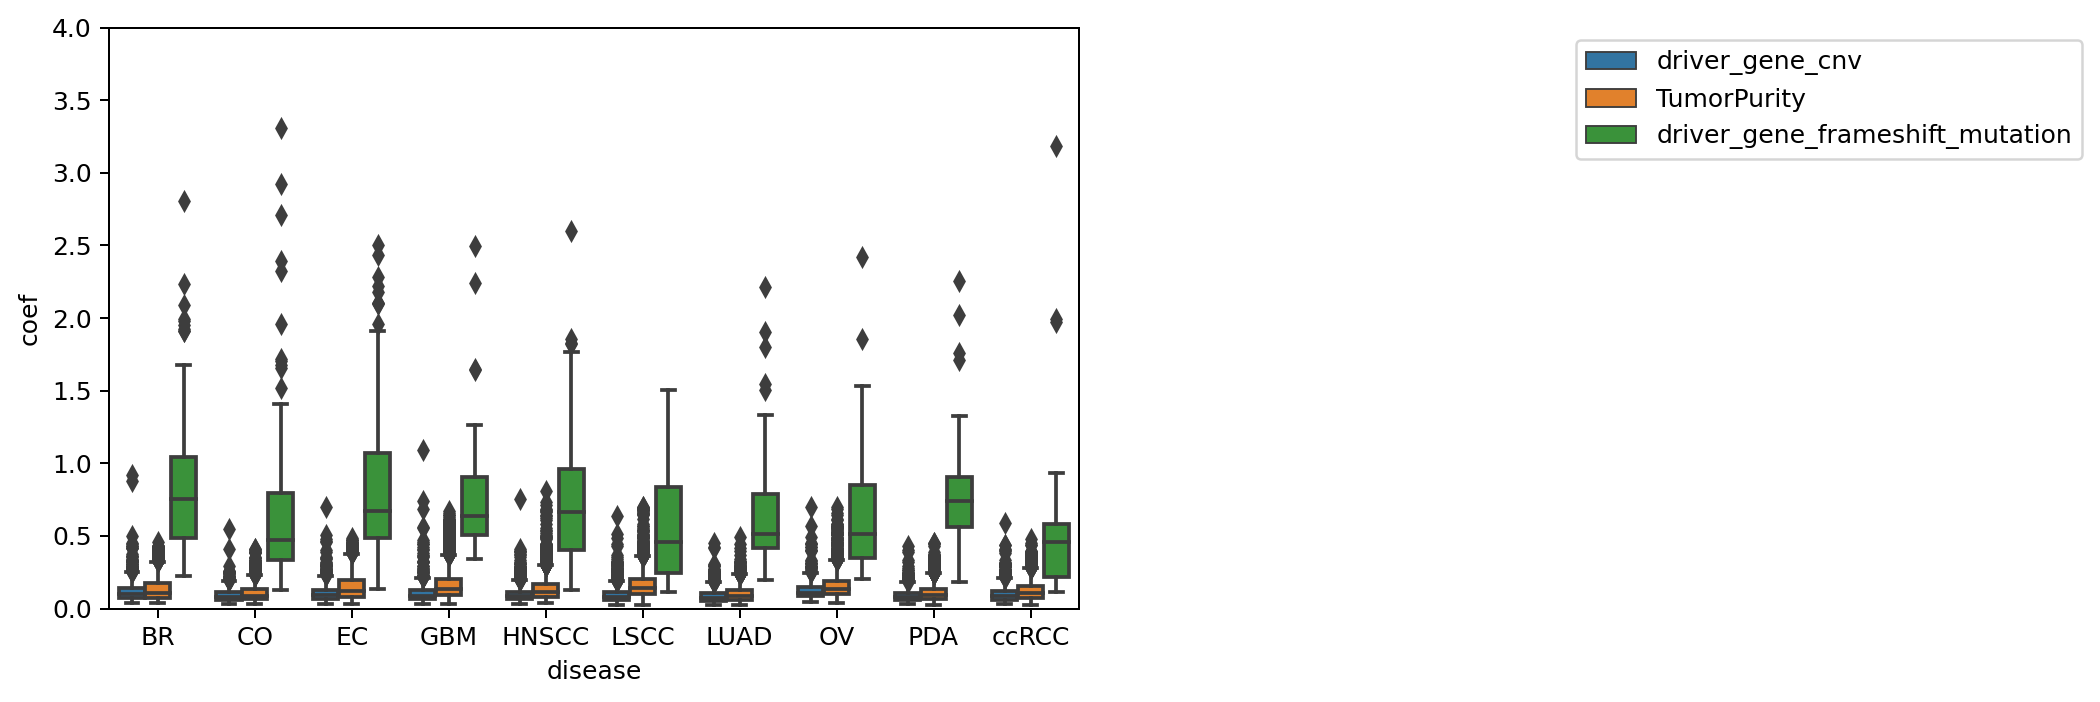

In [25]:
plot_aggregate_coefficients_boxplot(trunc_df)

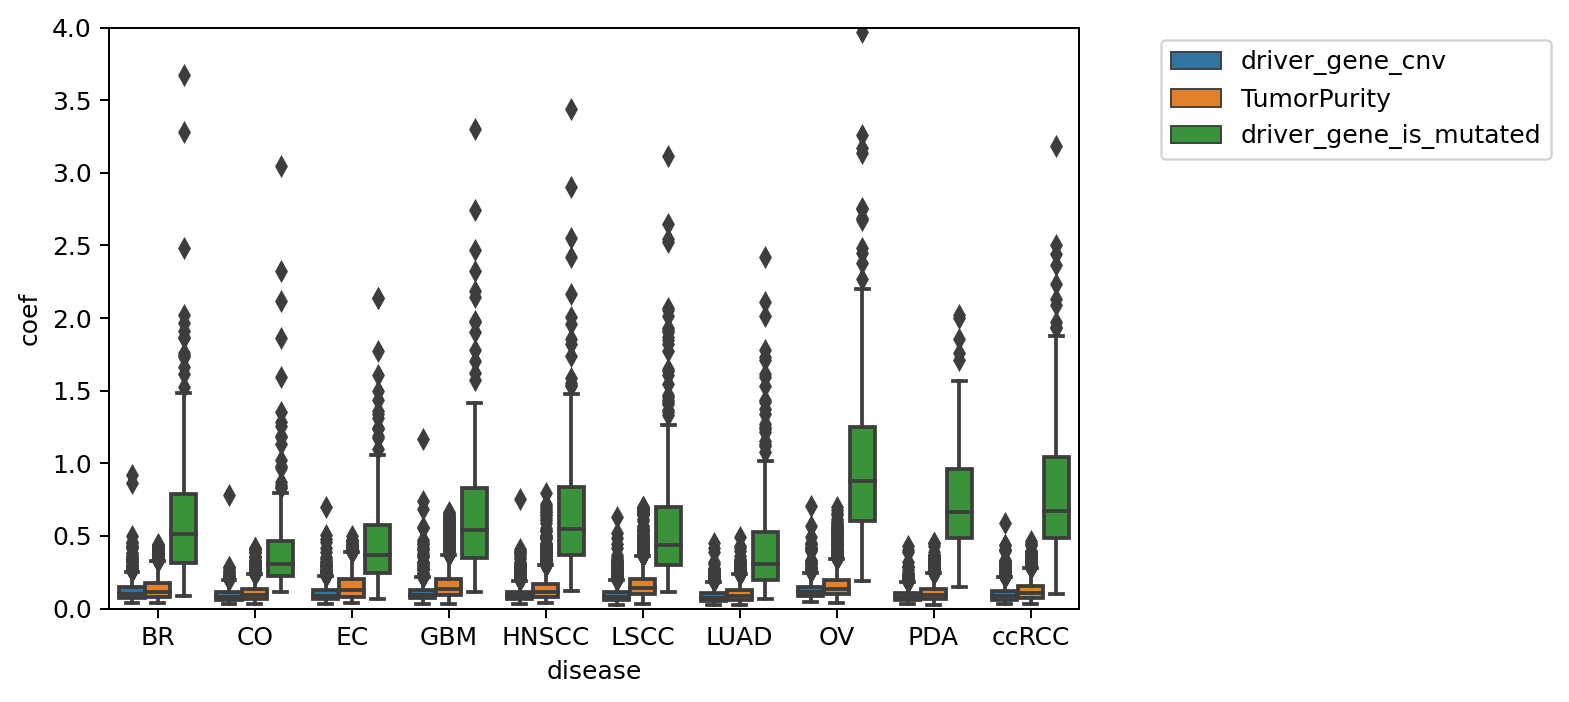

In [218]:
plot_aggregate_coefficients_boxplot(som_df)

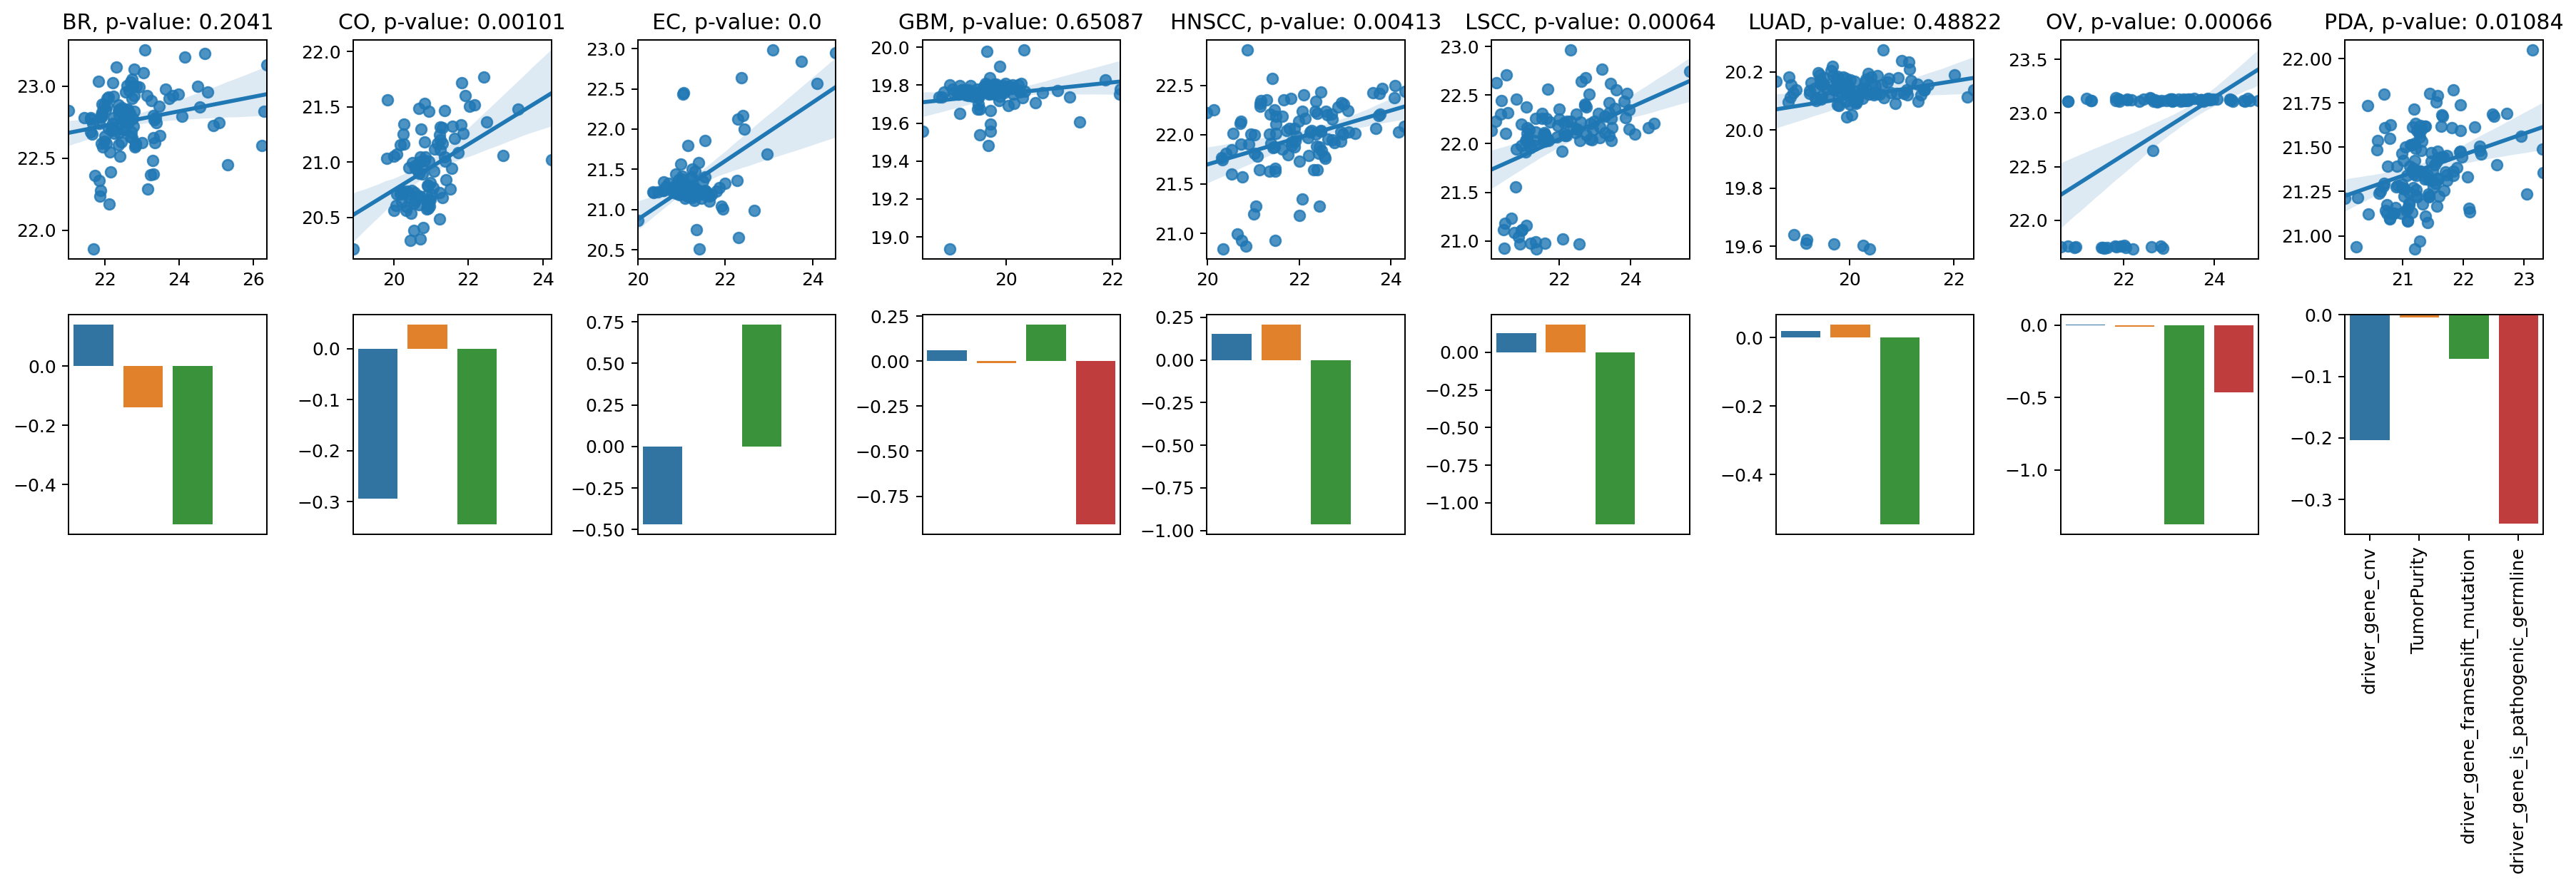

In [26]:
plot_scatter_feature(trunc, 'TP53_TP53', figsize=(20, 7))

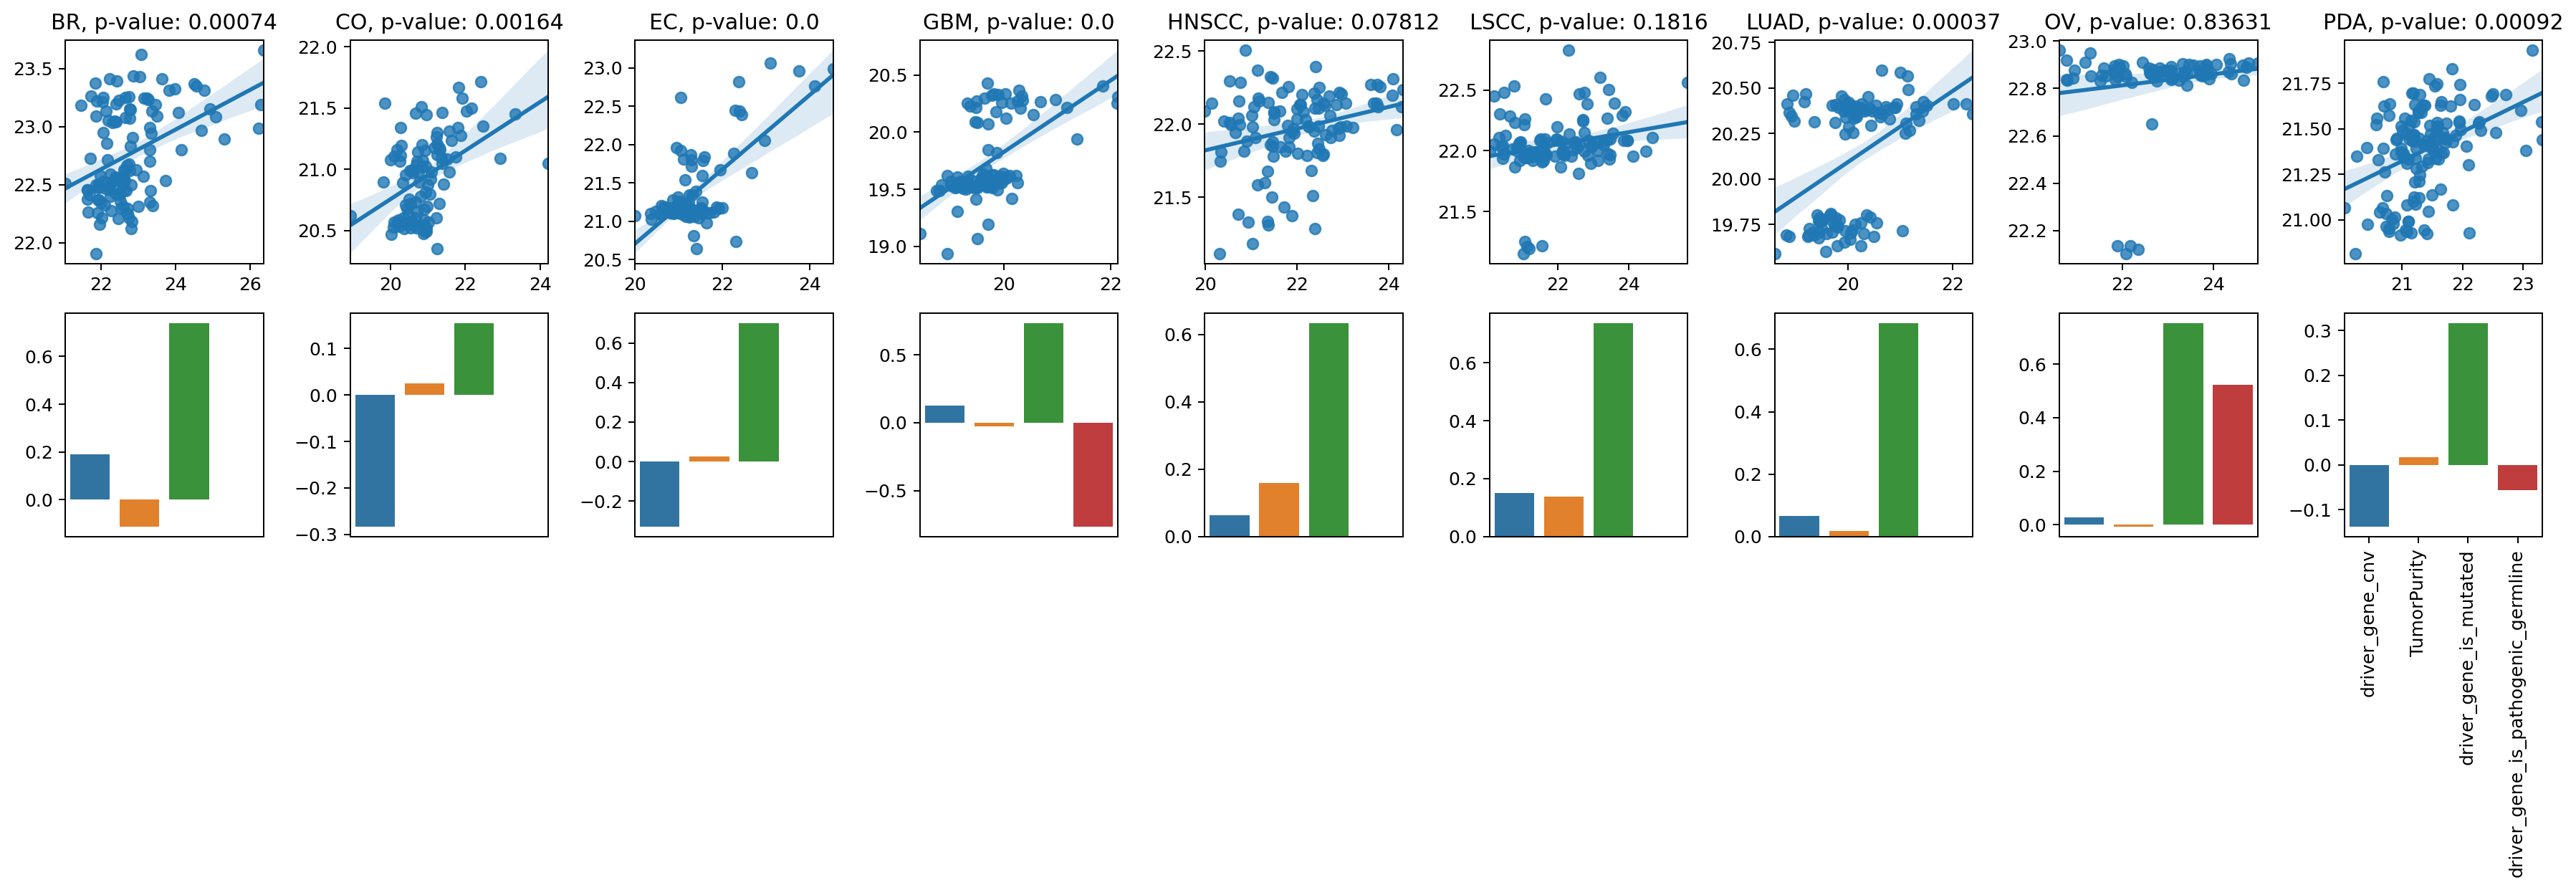

In [84]:
plot_scatter_feature(som, 'TP53_TP53', figsize=(20, 7))

In [ ]:
# x = combined[['TP53_cnv', 'TP53_is_mutated', 'TP53_is_pathogenic_germline', 'TP53_proteome', 'TumorPurity']].copy()
# x.columns = ['TP53 CNV', 'TP53 somatic mutation status', 'TP53 germline mutation status', 'ESR1 proteome', 'tumor purity']
# x['TP53 somatic mutation status'] = ['mutated' if m else 'wildtype' for m in x['TP53 somatic mutation status']]
# x

<AxesSubplot:xlabel='driver_gene_frameshift_mutation', ylabel='TP53_proteome'>

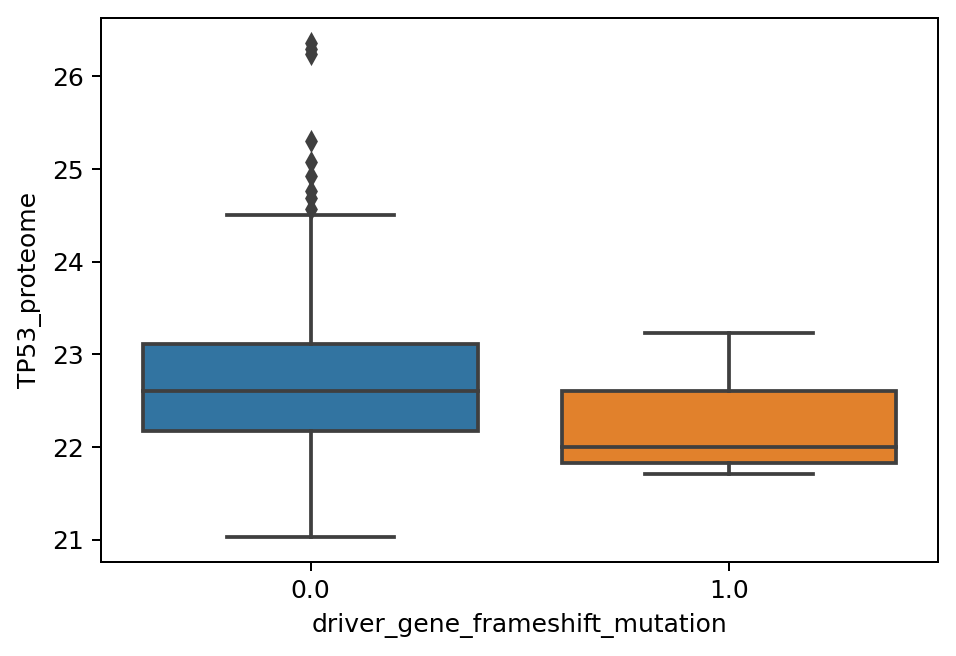

In [85]:
p = pd.concat((trunc['BR']['TP53_TP53']['X'], trunc['BR']['TP53_TP53']['y']), axis=1)
sns.boxplot(data=p, x='driver_gene_frameshift_mutation', y='TP53_proteome')

<AxesSubplot:xlabel='driver_gene_is_mutated', ylabel='TP53_proteome'>

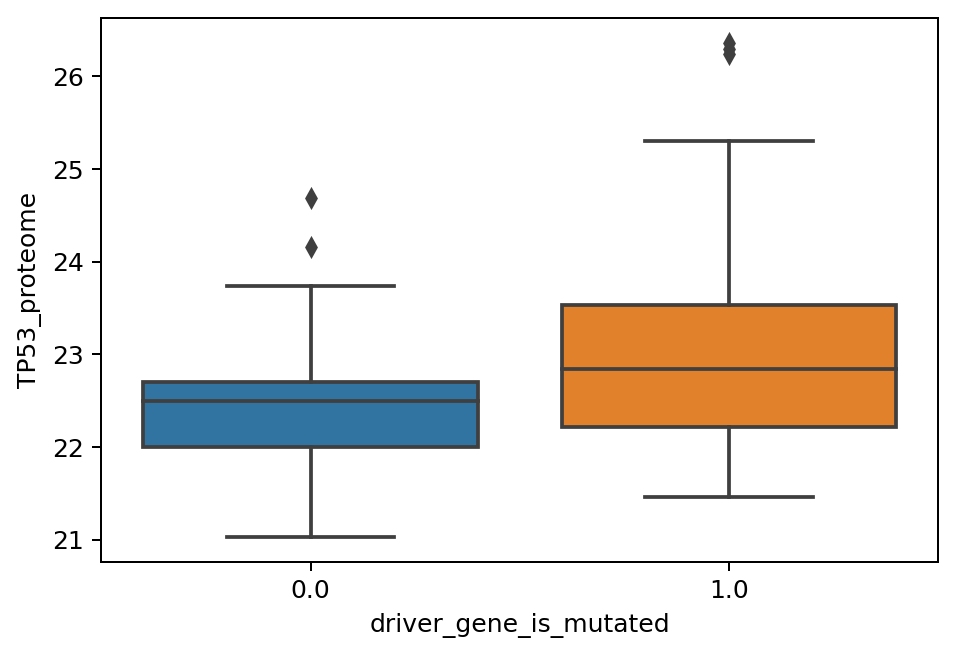

In [86]:
p = pd.concat((som['BR']['TP53_TP53']['X'], som['BR']['TP53_TP53']['y']), axis=1)
sns.boxplot(data=p, x='driver_gene_is_mutated', y='TP53_proteome')

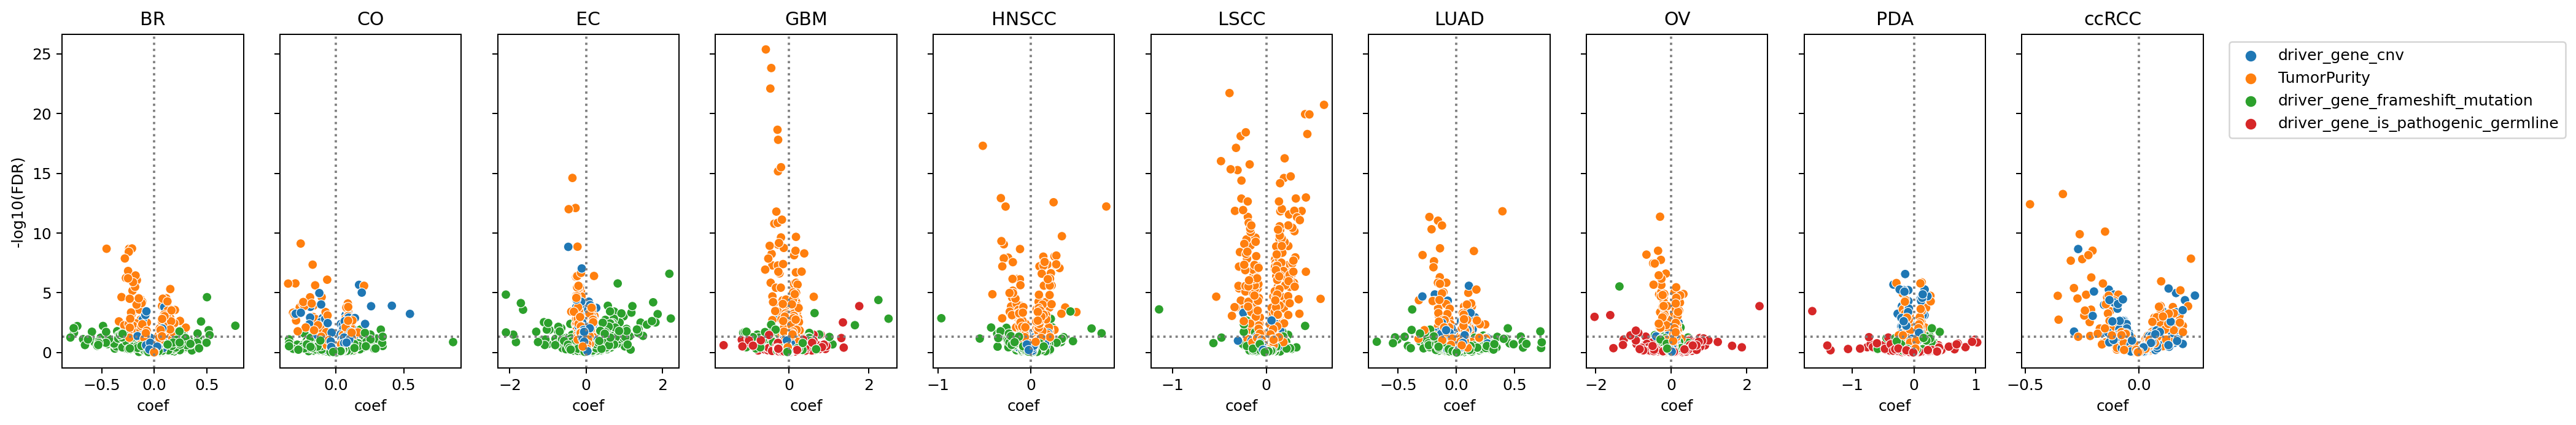

In [27]:
# do by disease
plot_feat_coef_by_disease('TP53', trunc_df)

In [ ]:
## overlay

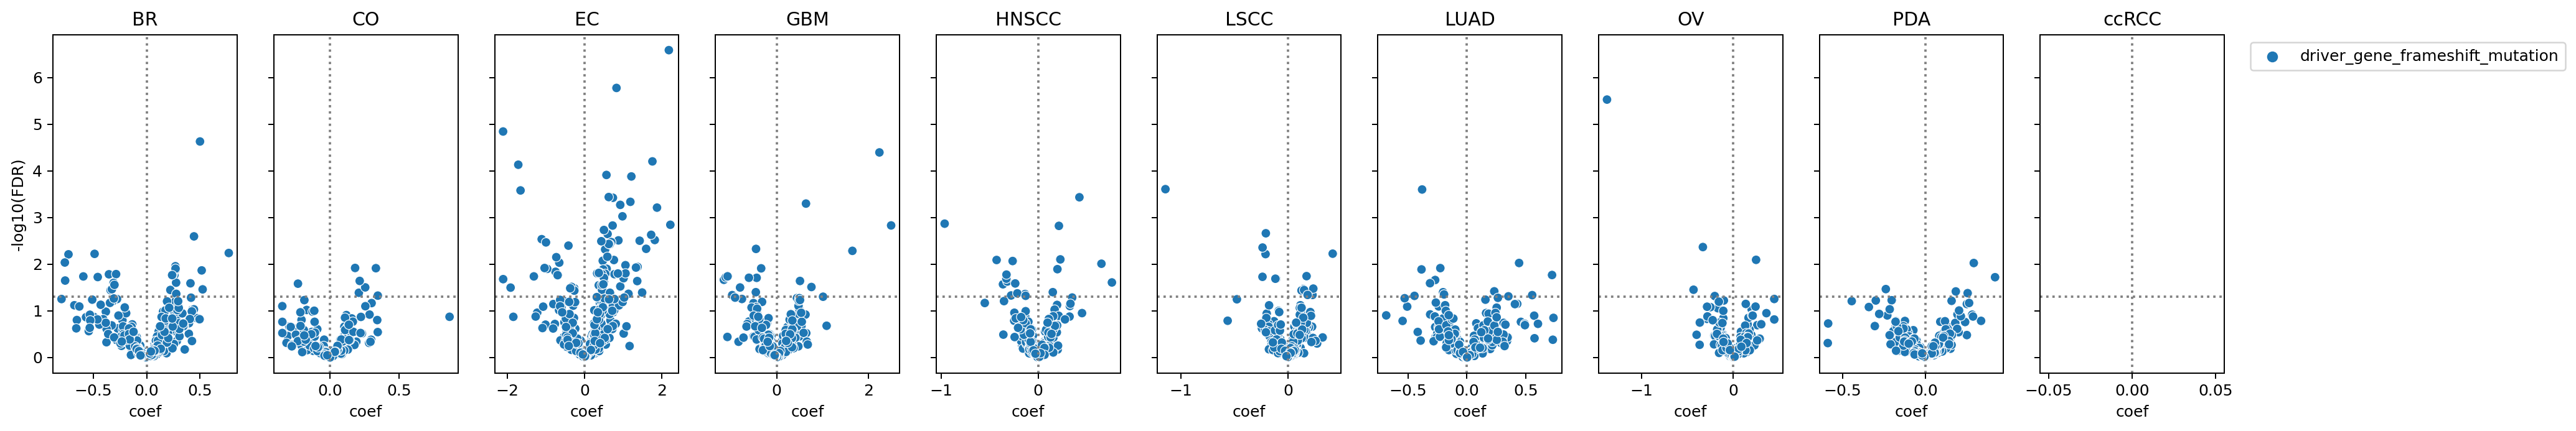

In [88]:
# do by disease
plot_feat_coef_by_disease('TP53', trunc_df, feats=['driver_gene_is_mutated',
                                                       'driver_gene_frameshift_mutation'])

In [221]:
import statsmodels
def test_for_difference(df1, df2, feat1, feat2, to_test='coef'):
    diseases = sorted(set(df1['disease']))
    data = []
    for disease in diseases:
        df1_filtered = df1[df1['disease']==disease]
        df1_filtered = df1_filtered[df1_filtered['feature']==feat1]
        df2_filtered = df2[df2['disease']==disease]
        df2_filtered = df2_filtered[df2_filtered['feature']==feat2]

        drivers = sorted(set(df1_filtered['driver']))
        for driver in drivers:
            x_df = df1_filtered[df1_filtered['driver']==driver]
            xs = [x for x in x_df[to_test] if not pd.isnull(x)]

            y_df = df2_filtered[df2_filtered['driver']==driver]
            ys = [x for x in y_df[to_test] if not pd.isnull(x)]

#             print(x_df.shape, y_df.shape, xs, ys)

            # ttest
            stat, pval, _ = statsmodels.stats.weightstats.ttest_ind(xs, ys)
            data.append([disease, driver, stat, pval, len([x for x in xs if x]), len([x for x in ys if x])])
    df = pd.DataFrame(data=data, columns=['disease', 'driver', 'statistic', 'p-value', 'df1_nonzero',
                                         'df2_nonzero'])
    return df

def test_for_difference_model(df1, df2, to_test='coef'):
    diseases = sorted(set(df1['disease']))
    data = []
    for disease in diseases:
        df1_filtered = df1[df1['disease']==disease]
        df2_filtered = df2[df2['disease']==disease]

        drivers = sorted(set(df1_filtered['driver']))
        for driver in drivers:
            x_df = df1_filtered[df1_filtered['driver']==driver]
            xs = [x for x, p in zip(x_df[to_test], x_df['FDR'])]

            y_df = df2_filtered[df2_filtered['driver']==driver]
            ys = [x for x, p in zip(y_df[to_test], y_df['FDR'])]
            
            
            
            xs, ys = zip(*[(x, y) for x, y in zip(xs, ys)
                     if not pd.isnull(x) if not pd.isnull(y)])

            # ttest
            stat, pval, _ = statsmodels.stats.weightstats.ttest_ind(xs, ys)
            data.append([disease, driver, stat, pval])
    df = pd.DataFrame(data=data, columns=['disease', 'driver', 'statistic', 'p-value'])
    return df

def get_sig_diff_df(df1, df2, feat1, feat2):
    diseases = sorted(set(df1['disease']))
    data = []
    for disease in diseases:
        df1_filtered = df1[df1['disease']==disease]
        df1_filtered = df1_filtered[df1_filtered['feature']==feat1]
        df2_filtered = df2[df2['disease']==disease]
        df2_filtered = df2_filtered[df2_filtered['feature']==feat2]

        drivers = sorted(set(df1_filtered['driver']))
        for driver in drivers:
            x_df = df1_filtered[df1_filtered['driver']==driver]
            total = x_df.shape[0]
            x_sig = x_df[x_df['FDR']<=.05]

            y_df = df2_filtered[df2_filtered['driver']==driver]
            y_sig = y_df[y_df['FDR']<=.05]
            
            data.append([disease, driver, x_sig.shape[0], y_sig.shape[0],
                        x_sig.shape[0] / x_df.shape[0], y_sig.shape[0] / y_df.shape[0],
                        (x_sig.shape[0] / x_df.shape[0]) - (y_sig.shape[0] / y_df.shape[0]),
                        total])
    df = pd.DataFrame(data=data, columns=['disease', 'driver', 'num_df1_sig', 'num_df2_sig',
                                         'frac_df1_sig', 'frac_df2_sig', 'frac_difference', 'num pairs'])
    return df  

In [102]:
trunc_df[trunc_df['disease']=='BR']

Unnamed: 0      coef       p-value           FDR  -log10(FDR)  \
0               0 -0.034225  7.199437e-02  1.367462e-01     0.864085   
1               1 -0.010397  5.822843e-01  7.083697e-01     0.149740   
2               2  0.000000           NaN           NaN          NaN   
3               3  0.000000           NaN           NaN          NaN   
4               4  0.179430  6.365821e-11  2.023076e-10     9.693988   
...           ...       ...           ...           ...          ...   
40039       40039  0.000000           NaN           NaN          NaN   
40040       40040  0.043891  2.490197e-01  3.781692e-01     0.422314   
40041       40041 -0.020199  5.949322e-01  7.187368e-01     0.143430   
40042       40042  0.000000           NaN           NaN          NaN   
40043       40043  0.000000           NaN           NaN          NaN   

                                  feature  driver  target disease  model_r2  \
0                         driver_gene_cnv    ABL1    ABI1      BR  0.012191   
1                             TumorPurity    ABL1    ABI1      BR  0.012191   
2         driver_gene_frameshift_mutation    ABL1    ABI1      BR  0.012191   
3      driver_gene_is_pathogenic_germline    ABL1    ABI1      BR  0.012191   
4                         driver_gene_cnv    ABL1    ABL1      BR  0.298532   
...                                   ...     ...     ...     ...       ...   
40039  driver_gene_is_pathogenic_germline  ZNF750  ZNF776      BR  0.003268   
40040                         TumorPurity  ZNF750  ZNF777      BR -0.004028   
40041                     driver_gene_cnv  ZNF750  ZNF777      BR -0.004028   
40042     driver_gene_frameshift_mutation  ZNF750  ZNF777      BR -0.004028   
40043  driver_gene_is_pathogenic_germline  ZNF750  ZNF777      BR -0.004028   

       model_r2_FDR  
0      2.913434e-01  
1      2.913434e-01  
2      2.913434e-01  
3      2.913434e-01  
4      2.121188e-08  
...             ...  
40039  4.289458e-01  
40040  5.822072e-01  
40041  5.822072e-01  
40042  5.822072e-01  
40043  5.822072e-01  

[40044 rows x 11 columns]

In [207]:
# find drivers with most different truncating vs somatic gene pairs
coef_diff_df = test_for_difference(trunc_df, som_df, 'driver_gene_frameshift_mutation', 'driver_gene_is_mutated',
                                  to_test='coef')
coef_diff_df

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:650: RuntimeWarning: invalid value encountered in double_scalars
  tstat = (value1 - value2 - diff) / std_diff
/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:995: RuntimeWarning: invalid value encountered in double_scalars
  (d1.nobs - 1 + d2.nobs - 1)


disease  driver  statistic   p-value  df1_nonzero  df2_nonzero
0         BR    ABL1  -2.068417  0.039850            0          104
1         BR   AJUBA        NaN       NaN            0            0
2         BR    AKT1   0.599122  0.549430            0          201
3         BR     ALB        NaN       NaN            0            0
4         BR     ALK  -1.251423  0.228768            0            9
...      ...     ...        ...       ...          ...          ...
1659   ccRCC    TSC2        NaN       NaN            0            0
1660   ccRCC     VHL   0.404719  0.685935          173          173
1661   ccRCC  ZBTB7B        NaN       NaN            0            0
1662   ccRCC   ZFHX3   0.151582  0.893426            2            2
1663   ccRCC  ZNF750  -0.460251  0.649479            0           13

[1664 rows x 6 columns]

In [208]:
p = coef_diff_df[coef_diff_df['df1_nonzero']>0]
p = p[~pd.isnull(p['statistic'])]
p = p.sort_values('statistic')
p['FDR'] = statsmodels.stats.multitest.fdrcorrection(p['p-value'].to_list())[1]
p['-log10(FDR)'] = [-np.log10(x) for x in p['FDR']]
p

disease  driver  statistic       p-value  df1_nonzero  df2_nonzero  \
191       CO   CDK12  -5.760492  1.895784e-08          169          169   
94        BR    MEN1  -4.996610  1.243470e-06          104          104   
1032    LUAD  CREBBP  -4.813317  2.520312e-06          131          131   
506      GBM  ARID1A  -4.722539  7.454477e-06           52           52   
1250      OV   KMT2D  -3.744638  2.827937e-04           59           59   
...      ...     ...        ...           ...          ...          ...   
212       CO   EP300   3.026336  2.692877e-03          149          149   
363       EC    CHD4   3.334153  1.200965e-03           51           51   
541      GBM  EEF1A1   3.843893  1.505936e-04          138          138   
1378     PDA   EP300   4.382670  1.513058e-05          194          194   
916     LSCC   KMT2D   4.647493  8.134371e-06           66           66   

           FDR  -log10(FDR)  
191   0.000006     5.215706  
94    0.000200     3.699890  
1032  0.000270     3.569162  
506   0.000522     3.282141  
1250  0.011347     1.945115  
...        ...          ...  
212   0.061744     1.209406  
363   0.035046     1.455357  
541   0.006906     2.160786  
1378  0.000809     3.091791  
916   0.000522     3.282141  

[321 rows x 8 columns]

In [209]:
# plot volcano
def plot_volcano(df, feat, fdr='-log10(FDR)', label=None, label_cut=.05, ax=None, size=6, hue=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    sns.scatterplot(data=df, x=feat, y=fdr, ax=ax, hue=hue)
    ax.axhline(y=-np.log10(.05), linestyle='dotted', color='gray')
    ax.axvline(x=0., linestyle='dotted', color='gray')
    
    if label is not None:
        for x, y, l in zip(df[feat], df[fdr], df[label]):
            if y >= -np.log10(label_cut):
                ax.annotate(l, (x, y), fontsize=size)
    
    return ax

<AxesSubplot:xlabel='statistic', ylabel='-log10(FDR)'>

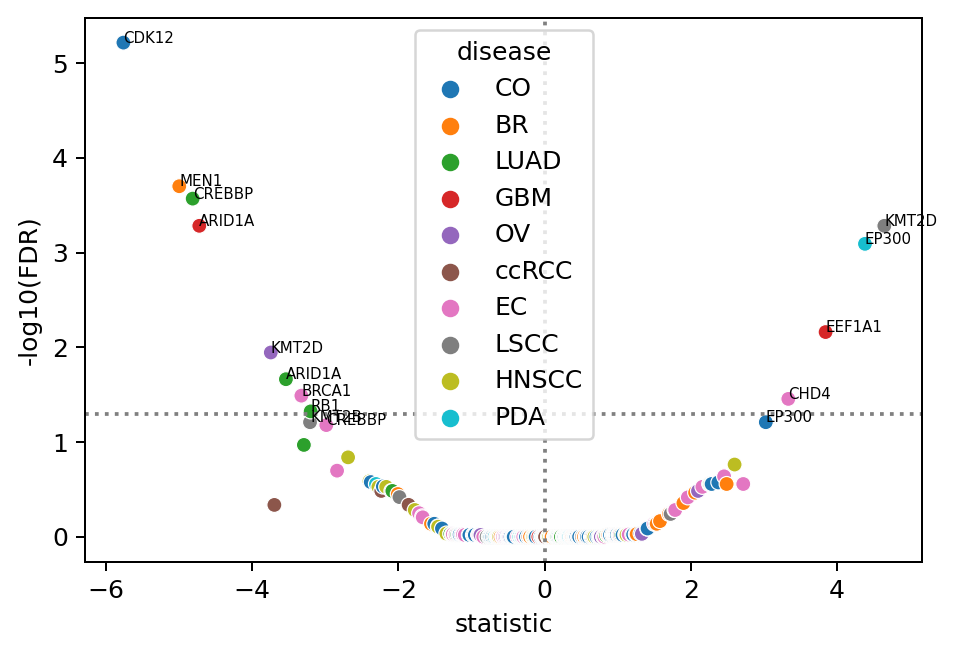

In [210]:
plot_volcano(p, feat='statistic', fdr='-log10(FDR)', label='driver', label_cut=.1, hue='disease')

In [133]:
diseases

['BR', 'CO', 'EC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV', 'PDA', 'ccRCC']

In [149]:
# diseases = sorted(set(p['disease']))
# fig, axs = plt.subplots(nrows=1, ncols=len(diseases), figsize=(20, 5))
# for disease in diseases:
#     for i, ax in enumerate(axs):
#         plot_volcano(p[p['disease']==disease], feat='statistic', fdr='-log10(FDR)', label='driver', label_cut=.1,
#                     ax=ax)
#         ax.set_title(disease)

In [138]:
diseases

['BR', 'CO', 'EC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV', 'PDA', 'ccRCC']

In [148]:
# diseases = sorted(set(p['disease']))
# fig, axs = plt.subplots(nrows=1, ncols=len(diseases), figsize=(20, 5))
# for i, (ax, disease) in enumerate(zip(axs, diseases)):
#     print(i, disease)
#     f1 = p[p['disease']==disease]
#     f = f1.iloc[:10]
#     f = pd.concat((f, f1.iloc[-10:]))
#     pal = sns.color_palette("Blues", len(data))
#     sns.barplot(data=f, x='statistic', y='driver', hue='-log10(FDR)', ax=ax)
#     ax.set_title(ax)

In [150]:
import altair as alt
diseases = sorted(set(p['disease']))
chart = None
for i, disease in enumerate(diseases):
    f1 = p[p['disease']==disease]
    f = f1.iloc[:5]
    f = pd.concat((f, f1.iloc[-5:]))
    
    c = alt.Chart(f, title=disease).mark_bar().encode(
        x=alt.X('statistic:Q'),
        y=alt.Y('driver:O', sort='-x'),
        color=alt.Color('-log10(FDR):Q')
    ).properties(width=250)
    if chart is None:
        chart = c
    else:
        chart = alt.hconcat(chart, c)
chart 

alt.HConcatChart(...)

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='type', ylabel='coef'>

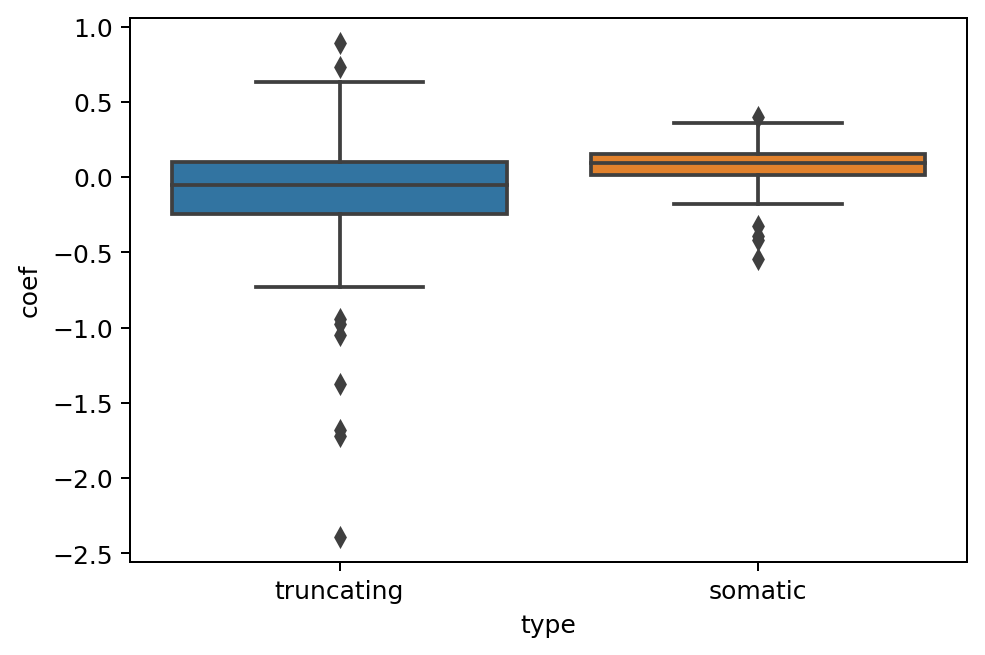

In [156]:
p1 = trunc_df[((trunc_df['disease']=='CO') & (trunc_df['driver']=='CDK12') & (trunc_df['feature']=='driver_gene_frameshift_mutation'))]
p2 = som_df[((som_df['disease']=='CO') & (som_df['driver']=='CDK12') & (som_df['feature']=='driver_gene_is_mutated'))]
p1['type'] = 'truncating'
p2['type'] = 'somatic'
p = pd.concat((p1, p2), axis=0)
sns.boxplot(data=p, x='type', y='coef')

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='type', ylabel='coef'>

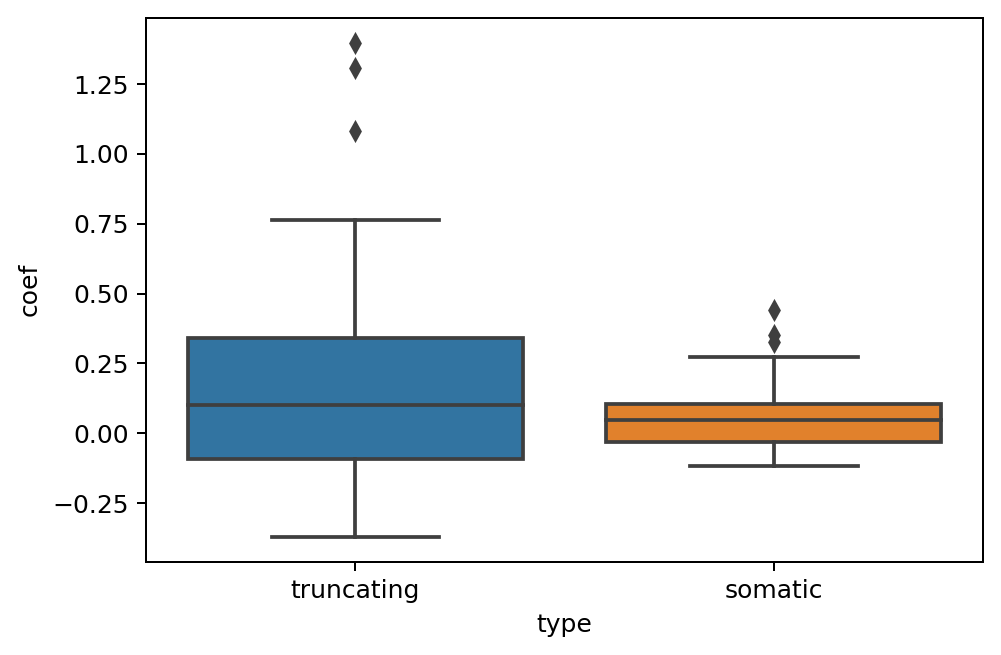

In [157]:
p1 = trunc_df[((trunc_df['disease']=='CO') & (trunc_df['driver']=='PIK3CA') & (trunc_df['feature']=='driver_gene_frameshift_mutation'))]
p2 = som_df[((som_df['disease']=='CO') & (som_df['driver']=='PIK3CA') & (som_df['feature']=='driver_gene_is_mutated'))]
p1['type'] = 'truncating'
p2['type'] = 'somatic'
p = pd.concat((p1, p2), axis=0)
sns.boxplot(data=p, x='type', y='coef')

In [200]:
sig_diff_df = get_sig_diff_df(trunc_df, som_df, 'driver_gene_frameshift_mutation', 'driver_gene_is_mutated')
sig_diff_df

disease  driver  num_df1_sig  num_df2_sig  frac_df1_sig  frac_df2_sig  \
0         BR    ABL1            0            3      0.000000      0.028846   
1         BR   AJUBA            0            0      0.000000      0.000000   
2         BR    AKT1            0            7      0.000000      0.034826   
3         BR     ALB            0            0      0.000000      0.000000   
4         BR     ALK            0            1      0.000000      0.111111   
...      ...     ...          ...          ...           ...           ...   
1659   ccRCC    TSC2            0            0      0.000000      0.000000   
1660   ccRCC     VHL            5            5      0.028902      0.028902   
1661   ccRCC  ZBTB7B            0            0      0.000000      0.000000   
1662   ccRCC   ZFHX3            0            0      0.000000      0.000000   
1663   ccRCC  ZNF750            0            0      0.000000      0.000000   

      frac_difference  num pairs  
0           -0.028846        104  
1            0.000000         85  
2           -0.034826        201  
3            0.000000         80  
4           -0.111111          9  
...               ...        ...  
1659         0.000000         26  
1660         0.000000        173  
1661         0.000000          1  
1662         0.000000          2  
1663         0.000000         13  

[1664 rows x 8 columns]

In [201]:
p = sig_diff_df.copy()
p = p[p['num pairs'] > 10]
p = p.sort_values('frac_difference')

In [202]:
import altair as alt
diseases = sorted(set(p['disease']))
chart = None
for i, disease in enumerate(diseases):
    f1 = p[p['disease']==disease]
    f = f1.iloc[:5]
    f = pd.concat((f, f1.iloc[-5:]))
    
    c = alt.Chart(f, title=disease).mark_bar().encode(
        x=alt.X('frac_difference:Q', title='Fraction difference'),
        y=alt.Y('driver:O', sort='-x'),
#         color=alt.Color('-log10(FDR):Q')
    ).properties(width=250)
    if chart is None:
        chart = c
    else:
        chart = alt.hconcat(chart, c)
chart 

alt.HConcatChart(...)

<AxesSubplot:xlabel='driver_gene_is_mutated', ylabel='TP53_proteome'>

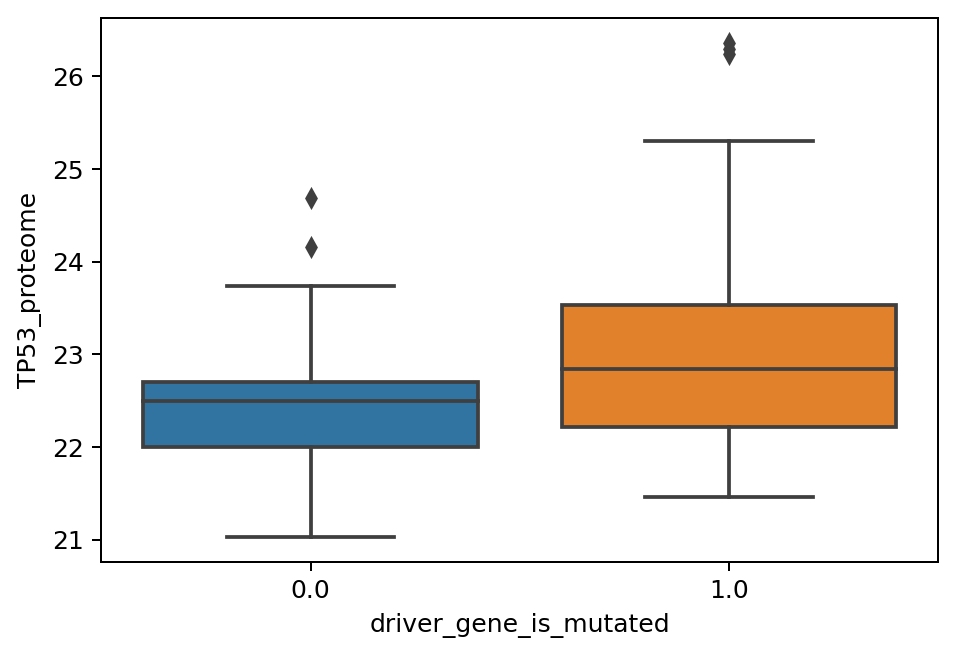

In [171]:
p = pd.concat((som['BR']['TP53_TP53']['X'], som['BR']['TP53_TP53']['y']), axis=1)
sns.boxplot(data=p, x='driver_gene_is_mutated', y='TP53_proteome')

In [ ]:
sig_diff_df = get_sig_diff_df(trunc, som, 'driver_gene_frameshift_mutation', 'driver_gene_is_mutated')
sig_diff_df

In [181]:
def gather_dataframe(r1, r2, gene, disease):
    keys = [k for k in r1[disease].keys() if gene==k.split('_')[0]]
    df = None
    data = []
    for k in keys:
        x1, y1 = r1[disease][k]['X'].copy(), r1[disease][k]['y'].copy()
        x2, y2 = r2[disease][k]['X'].copy(), r2[disease][k]['y'].copy()
        
        y1 = [x for x, s in zip(y1.iloc[:, 0].to_list(), x1['driver_gene_frameshift_mutation'])
             if s==1]
        y2 = [x for x, s in zip(y2.iloc[:, 0].to_list(), x2['driver_gene_is_mutated'])
             if s==1]
        
        stat, pval, _ = statsmodels.stats.weightstats.ttest_ind(y1, y2)
        
        data.append([k, stat, pval])
        
    df = pd.DataFrame(data=data, columns=['key', 'statistic', 'p-value'])
    return df

In [184]:
gene = 'TP53'
disease = 'BR'
df = gather_dataframe(trunc, som, gene, disease)
df.sort_values('statistic')

key  statistic   p-value
145     TP53_IGF1R  -3.422238  0.001145
179      TP53_MLH1  -2.655995  0.010194
313       TP53_YY1  -2.393204  0.019959
194     TP53_NUAK1  -2.390548  0.020091
5      TP53_ANTXR1  -2.265992  0.027200
..             ...        ...       ...
55       TP53_CCT7   2.364150  0.021441
58     TP53_CDC25C   2.418185  0.018759
159     TP53_KIFC3   2.533357  0.014023
288   TP53_TP53BP2   3.017492  0.003782
141  TP53_HSP90AB1   3.463974  0.001007

[315 rows x 3 columns]

<AxesSubplot:xlabel='mutation_status', ylabel='KIFC3_proteome'>

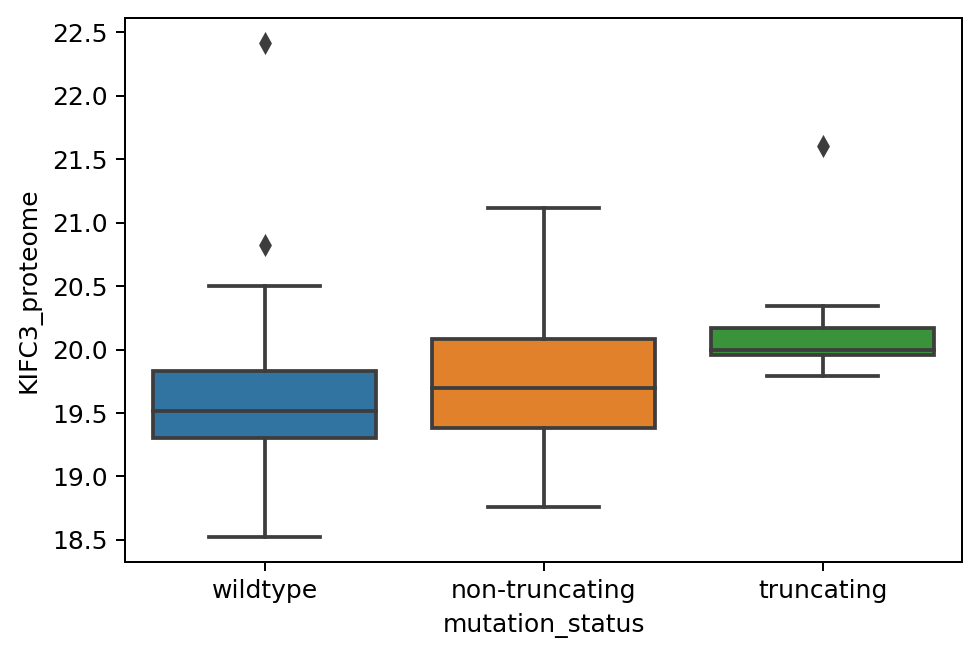

In [198]:

p1 = pd.concat((trunc['BR']['TP53_KIFC3']['X'], trunc['BR']['TP53_KIFC3']['y']), axis=1)[['driver_gene_frameshift_mutation',
                                                                                         'KIFC3_proteome']]
p2 = pd.concat((som['BR']['TP53_KIFC3']['X'], som['BR']['TP53_KIFC3']['y']), axis=1)[['driver_gene_is_mutated',
                                                                                     'KIFC3_proteome']]

def temp(f, s):
    if f==0 and s==0:
        return 'wildtype'
    if f==1:
        return 'truncating'
    if s==1:
        return 'non-truncating'
p1['mutation_status'] = [temp(f, s) for f, s in zip(p1['driver_gene_frameshift_mutation'], p2['driver_gene_is_mutated'])]
sns.boxplot(data=p1, x='mutation_status', y='KIFC3_proteome', order=['wildtype', 'non-truncating', 'truncating'])

<AxesSubplot:xlabel='mutation_status', ylabel='IGF1R_proteome'>

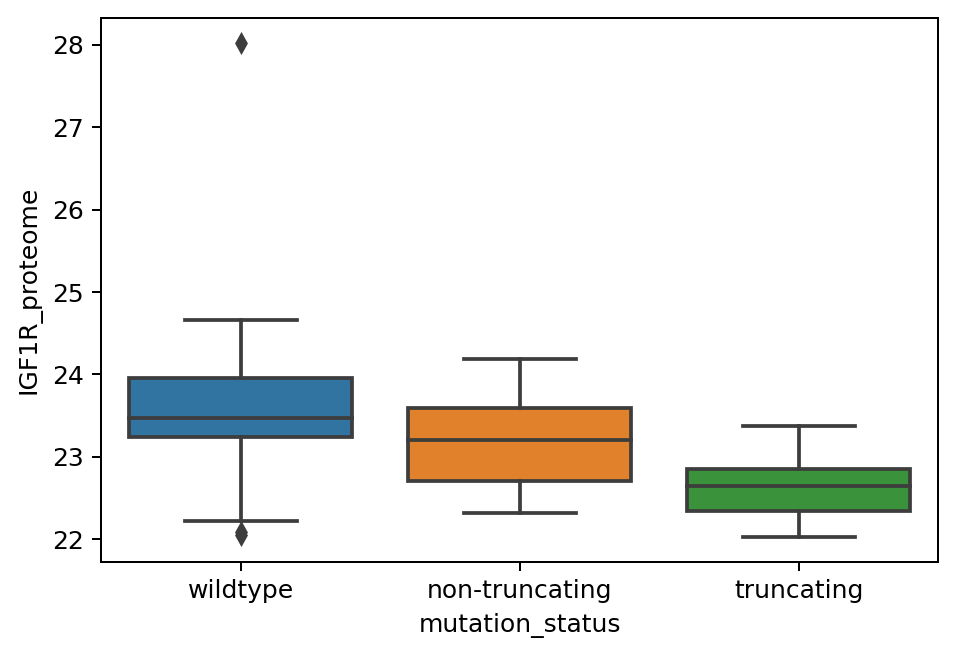

In [199]:

p1 = pd.concat((trunc['BR']['TP53_IGF1R']['X'], trunc['BR']['TP53_IGF1R']['y']), axis=1)[['driver_gene_frameshift_mutation',
                                                                                         'IGF1R_proteome']]
p2 = pd.concat((som['BR']['TP53_IGF1R']['X'], som['BR']['TP53_IGF1R']['y']), axis=1)[['driver_gene_is_mutated',
                                                                                     'IGF1R_proteome']]

def temp(f, s):
    if f==0 and s==0:
        return 'wildtype'
    if f==1:
        return 'truncating'
    if s==1:
        return 'non-truncating'
p1['mutation_status'] = [temp(f, s) for f, s in zip(p1['driver_gene_frameshift_mutation'], p2['driver_gene_is_mutated'])]
sns.boxplot(data=p1, x='mutation_status', y='IGF1R_proteome', order=['wildtype', 'non-truncating', 'truncating'])

<AxesSubplot:xlabel='driver_gene_is_mutated', ylabel='IGF1R_proteome'>

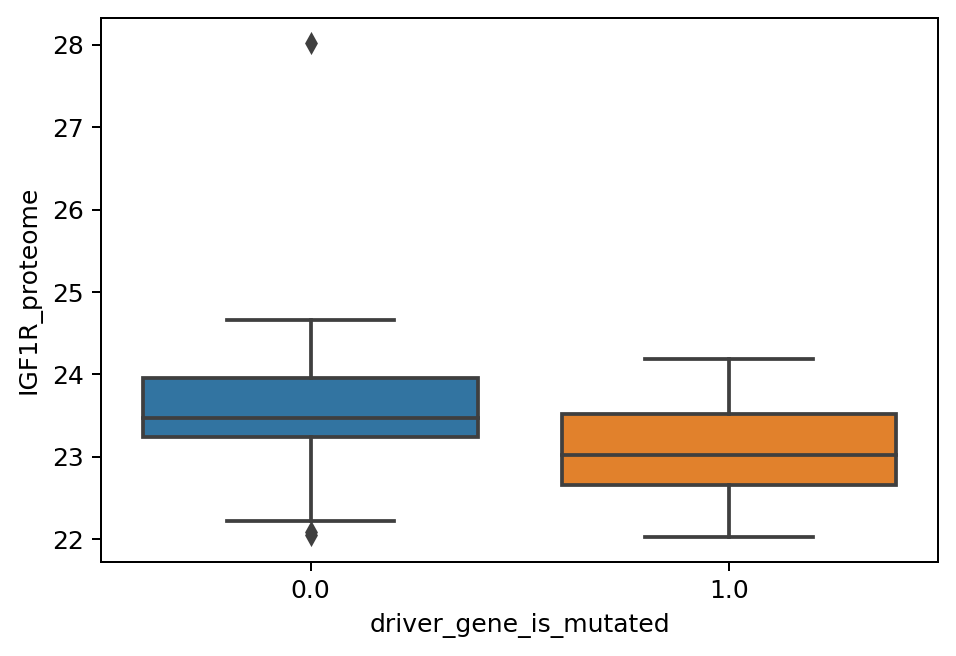

In [190]:

p = pd.concat((som['BR']['TP53_IGF1R']['X'], som['BR']['TP53_IGF1R']['y']), axis=1)
sns.boxplot(data=p, x='driver_gene_is_mutated', y='IGF1R_proteome')
    

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<AxesSubplot:xlabel='type', ylabel='coef'>

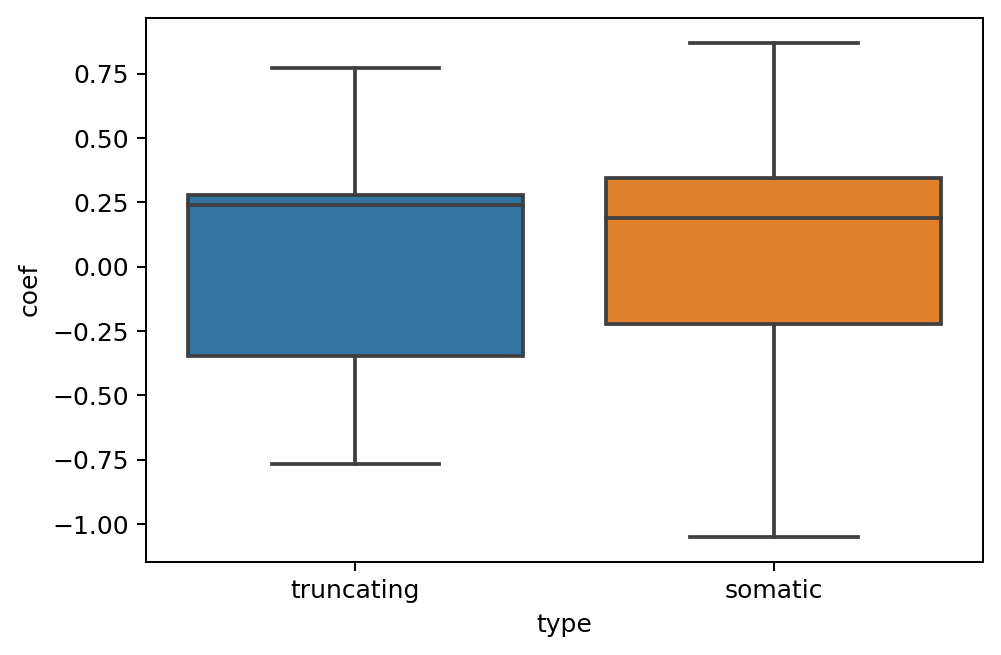

In [170]:
gene = 'TP53'
disease = 'BR'

p1 = trunc_df[((trunc_df['disease']==disease) & (trunc_df['driver']==gene) & (trunc_df['feature']=='driver_gene_frameshift_mutation'))]
p2 = som_df[((som_df['disease']==disease) & (som_df['driver']==gene) & (som_df['feature']=='driver_gene_is_mutated'))]
p1['type'] = 'truncating'
p2['type'] = 'somatic'
p = pd.concat((p1, p2), axis=0)
p = p[p['FDR']<=.05]
sns.boxplot(data=p, x='type', y='coef')

In [169]:
d_df = test_for_difference(trunc_df, som_df, 'driver_gene_frameshift_mutation', 'driver_gene_is_mutated',
                                  to_test='coef')
d_df

Unnamed: 0      coef   p-value       FDR  -log10(FDR)  \
37662     37662.0 -0.568547  0.072061  0.136841     0.863782   
37666     37666.0  0.228606  0.102285  0.184718     0.733491   
37670     37670.0 -0.046102  0.778134  0.856487     0.067279   
37674     37674.0 -0.108999  0.442545  0.585434     0.232522   
37678     37678.0 -0.023704  0.847174  0.901663     0.044956   
...           ...       ...       ...       ...          ...   
38902         NaN -0.252344  0.000031  0.000106     3.974740   
38906         NaN -0.002878  0.945584  0.971492     0.012561   
38910         NaN  0.029921  0.473079  0.647889     0.188499   
38914         NaN -0.031798  0.608751  0.757632     0.120542   
38918         NaN -0.482739  0.000023  0.000078     4.107001   

                               feature driver   target disease  model_r2  \
37662  driver_gene_frameshift_mutation   TP53    ACTA2      BR  0.064602   
37666  driver_gene_frameshift_mutation   TP53      ADA      BR  0.296435   
37670  driver_gene_frameshift_mutation   TP53    AIFM2      BR  0.102275   
37674  driver_gene_frameshift_mutation   TP53     AKT1      BR  0.024976   
37678  driver_gene_frameshift_mutation   TP53    ALOX5      BR  0.272912   
...                                ...    ...      ...     ...       ...   
38902           driver_gene_is_mutated   TP53      XPC      BR  0.143448   
38906           driver_gene_is_mutated   TP53    XRCC6      BR  0.038914   
38910           driver_gene_is_mutated   TP53     XRN2      BR  0.068715   
38914           driver_gene_is_mutated   TP53      YY1      BR  0.029403   
38918           driver_gene_is_mutated   TP53  ZNF385A      BR  0.127367   

       model_r2_FDR        type  
37662  4.042031e-02  truncating  
37666  7.432198e-08  truncating  
37670  7.354526e-03  truncating  
37674  2.088049e-01  truncating  
37678  4.095778e-07  truncating  
...             ...         ...  
38902  9.908890e-04     somatic  
38906  1.214264e-01     somatic  
38910  3.471844e-02     somatic  
38914  1.785953e-01     somatic  
38918  2.226532e-03     somatic  

[630 rows x 12 columns]

In [50]:
a = p[p['feature']=='driver_gene_frameshift_mutation']
a = a[a['coef'] < .1]
a

coef       p-value           FDR  -log10(FDR)  \
4957    1.541108e-18  4.469809e-04  1.481842e-03     2.829198   
4962    1.670150e-18  1.064774e-05  3.838935e-05     4.415789   
4967    2.290856e-18  7.345164e-11  2.839546e-10     9.546751   
4972    3.133486e-18  3.122587e-09  1.194656e-08     7.922757   
4977    1.747522e-18  4.548853e-04  1.506910e-03     2.821913   
...              ...           ...           ...          ...   
388802  5.363568e-17  1.162880e-05  3.897651e-05     4.409197   
388807  4.163813e-17  5.809639e-04  1.811820e-03     2.741885   
431482  1.235260e-15  1.387477e-02  3.509919e-02     1.454703   
431487  2.250039e-15  7.129918e-03  1.891875e-02     1.723108   
431542  2.866481e-15  1.437000e-02  3.626888e-02     1.440466   

                                feature driver    target disease  model_r2  \
4957    driver_gene_frameshift_mutation  BRCA1      ABL1      BR -0.027735   
4962    driver_gene_frameshift_mutation  BRCA1  ABRAXAS1      BR -0.013281   
4967    driver_gene_frameshift_mutation  BRCA1    ACTL6A      BR -0.016114   
4972    driver_gene_frameshift_mutation  BRCA1      AKT1      BR  0.078931   
4977    driver_gene_frameshift_mutation  BRCA1      AKT2      BR -0.004822   
...                                 ...    ...       ...     ...       ...   
388802  driver_gene_frameshift_mutation  BRCA1       VCP     PDA  0.044236   
388807  driver_gene_frameshift_mutation  BRCA1       WRN     PDA  0.011804   
431482  driver_gene_frameshift_mutation    ATM       ATM   ccRCC  0.064135   
431487  driver_gene_frameshift_mutation    ATM       ATR   ccRCC  0.107647   
431542  driver_gene_frameshift_mutation    ATM     CHEK1   ccRCC  0.161219   

        model_r2_FDR  
4957        0.954465  
4962        0.740657  
4967        0.786414  
4972        0.031729  
4977        0.608503  
...              ...  
388802      0.110358  
388807      0.385900  
431482      0.074713  
431487      0.013063  
431542      0.001083  

[303 rows x 10 columns]

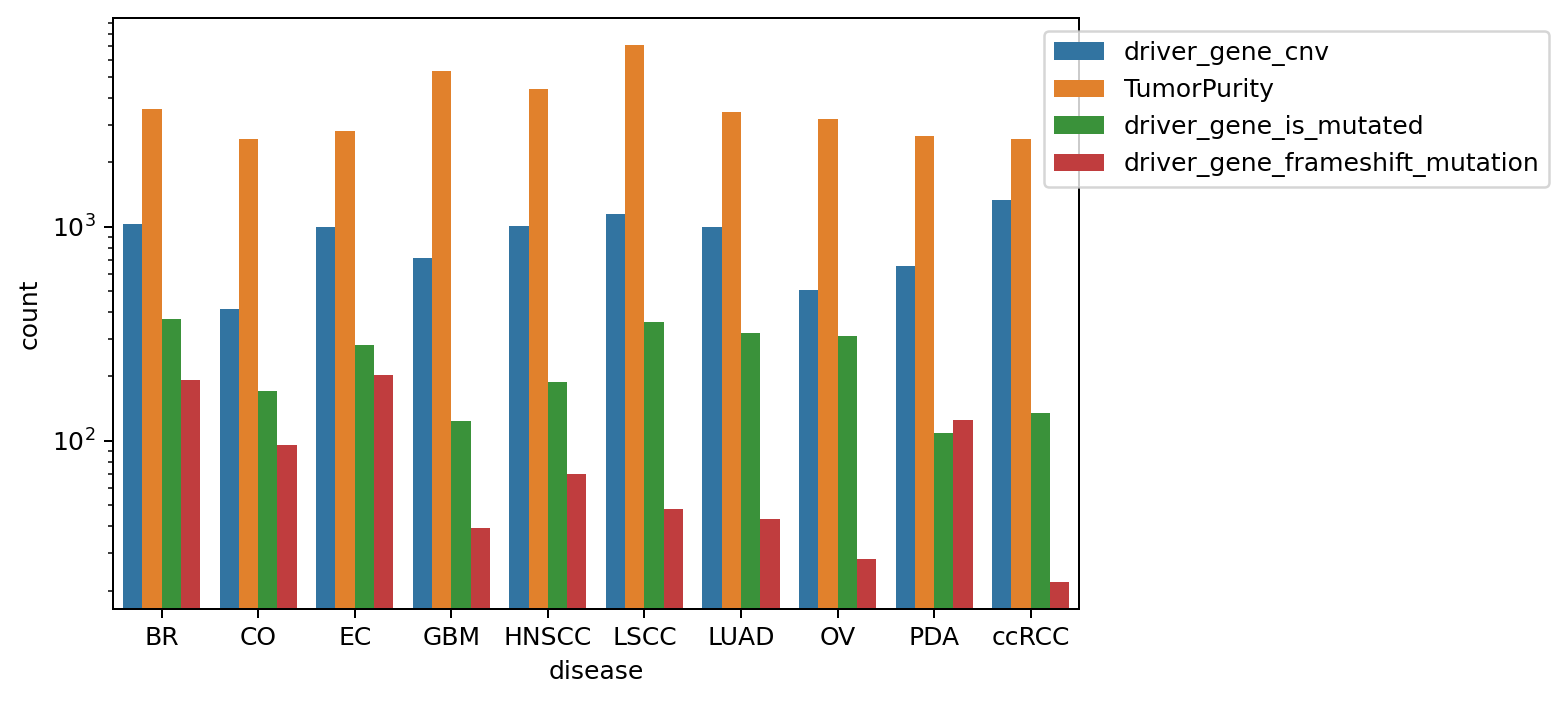

In [46]:
fig, axs = plt.subplots(figsize=(10, 4))
sns.countplot(data=p, x='disease', hue='feature')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.tight_layout()
# plt.savefig(os.path.join(figdir, 'aggregated_significant_feature_coefficients_countplot.pdf'))

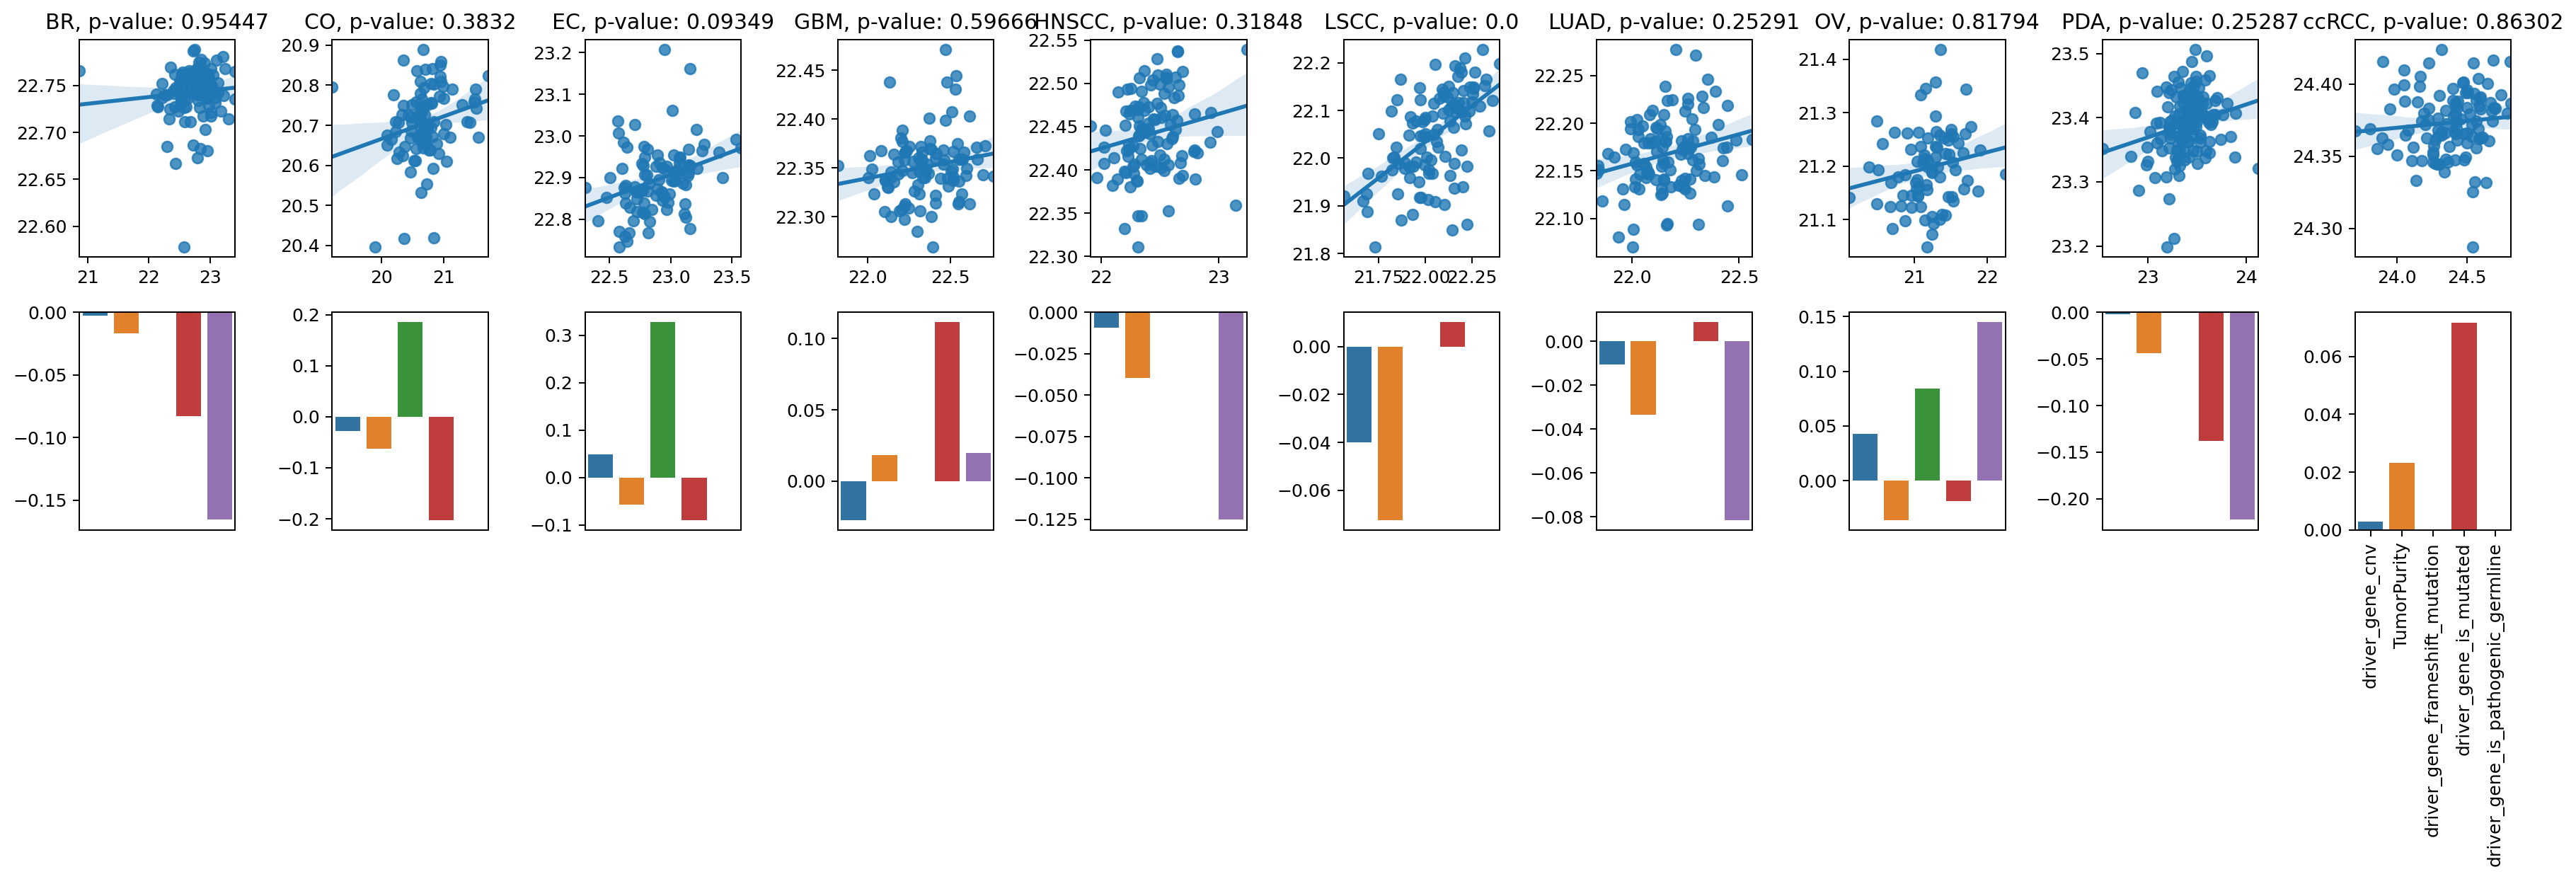

In [52]:
plot_scatter_feature(truncating, 'BRCA1_ABL1', figsize=(20, 7))

##### expression vs. protein

In [203]:
prot = load_results_dict('../results/model_results_cnv_pur_som_germ_target_prot.json')

In [204]:
prot_df = pd.read_csv('../results/model_results_cnv_pur_som_germ_target_prot.txt', sep='\t')

In [205]:
exp = load_results_dict('../results/model_results_cnv_pur_som_germ_target_exp.json')

In [206]:
exp_df = pd.read_csv('../results/model_results_cnv_pur_som_germ_target_exp.txt', sep='\t')
exp_df

coef       p-value           FDR  -log10(FDR)  \
0       -2296.356102  8.825868e-01  9.443458e-01     0.024869   
1       -3697.054627  8.124165e-01  9.069838e-01     0.042400   
2      -55735.594358  6.445640e-01  8.080267e-01     0.092574   
3           0.000000           NaN           NaN          NaN   
4       49168.384392  1.001844e-11  4.381812e-11    10.358346   
...              ...           ...           ...          ...   
621475      0.000000           NaN           NaN          NaN   
621476   2128.848563  1.451161e-01  2.593052e-01     0.586189   
621477  -5312.962544  3.842869e-04  1.157616e-03     2.936436   
621478   4746.539522  7.541457e-01  8.580521e-01     0.066486   
621479      0.000000           NaN           NaN          NaN   

                                   feature  driver   target disease  model_r2  \
0                          driver_gene_cnv    ABL1     ABI1      BR -0.023628   
1                              TumorPurity    ABL1     ABI1      BR -0.023628   
2                   driver_gene_is_mutated    ABL1     ABI1      BR -0.023628   
3       driver_gene_is_pathogenic_germline    ABL1     ABI1      BR -0.023628   
4                          driver_gene_cnv    ABL1     ABL1      BR  0.342304   
...                                    ...     ...      ...     ...       ...   
621475  driver_gene_is_pathogenic_germline  ZNF750  ZSCAN25   ccRCC  0.258600   
621476                         TumorPurity  ZNF750  ZSCAN32   ccRCC  0.118073   
621477                     driver_gene_cnv  ZNF750  ZSCAN32   ccRCC  0.118073   
621478              driver_gene_is_mutated  ZNF750  ZSCAN32   ccRCC  0.118073   
621479  driver_gene_is_pathogenic_germline  ZNF750  ZSCAN32   ccRCC  0.118073   

        model_r2_FDR  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
621475           NaN  
621476           NaN  
621477           NaN  
621478           NaN  
621479           NaN  

[621480 rows x 10 columns]

In [249]:
exp_df['label'] = [f'{x}_{y}_{d}' for x, y, d in zip(exp_df['driver'], exp_df['target'], exp_df['disease'])]
exp_df2 = exp_df[['label', 'model_r2']].groupby('label').mean()
exp_df2['driver'], exp_df2['target'], exp_df2['disease'] = zip(*[x.split('_') for x in exp_df2.index])
exp_df2

model_r2  driver   target disease
label                                                  
ABL1_ABI1_BR         -0.023628    ABL1     ABI1      BR
ABL1_ABI1_CO          0.004554    ABL1     ABI1      CO
ABL1_ABI1_EC         -0.022321    ABL1     ABI1      EC
ABL1_ABI1_GBM         0.035829    ABL1     ABI1     GBM
ABL1_ABI1_HNSCC       0.025195    ABL1     ABI1   HNSCC
...                        ...     ...      ...     ...
ZNF750_ZSCAN32_LSCC   0.085155  ZNF750  ZSCAN32    LSCC
ZNF750_ZSCAN32_LUAD   0.058216  ZNF750  ZSCAN32    LUAD
ZNF750_ZSCAN32_OV     0.048416  ZNF750  ZSCAN32      OV
ZNF750_ZSCAN32_PDA    0.000254  ZNF750  ZSCAN32     PDA
ZNF750_ZSCAN32_ccRCC  0.118073  ZNF750  ZSCAN32   ccRCC

[155370 rows x 4 columns]

In [250]:
prot_df['label'] = [f'{x}_{y}_{d}' for x, y, d in zip(prot_df['driver'], prot_df['target'], prot_df['disease'])]
prot_df2 = prot_df[['label', 'model_r2']].groupby('label').mean()
prot_df2['driver'], prot_df2['target'], prot_df2['disease'] = zip(*[x.split('_') for x in prot_df2.index])
prot_df2

model_r2  driver   target disease
label                                                 
ABL1_ABI1_BR         0.005537    ABL1     ABI1      BR
ABL1_ABI1_CO         0.059323    ABL1     ABI1      CO
ABL1_ABI1_EC        -0.020689    ABL1     ABI1      EC
ABL1_ABI1_GBM       -0.027484    ABL1     ABI1     GBM
ABL1_ABI1_HNSCC      0.040130    ABL1     ABI1   HNSCC
...                       ...     ...      ...     ...
ZNF750_ZNF777_GBM    0.054313  ZNF750   ZNF777     GBM
ZNF750_ZNF777_LSCC   0.094722  ZNF750   ZNF777    LSCC
ZNF750_ZSCAN25_LSCC  0.056778  ZNF750  ZSCAN25    LSCC
ZNF750_ZSCAN32_EC    0.006860  ZNF750  ZSCAN32      EC
ZNF750_ZSCAN32_LSCC -0.005296  ZNF750  ZSCAN32    LSCC

[94713 rows x 4 columns]

<AxesSubplot:xlabel='disease', ylabel='model_r2'>

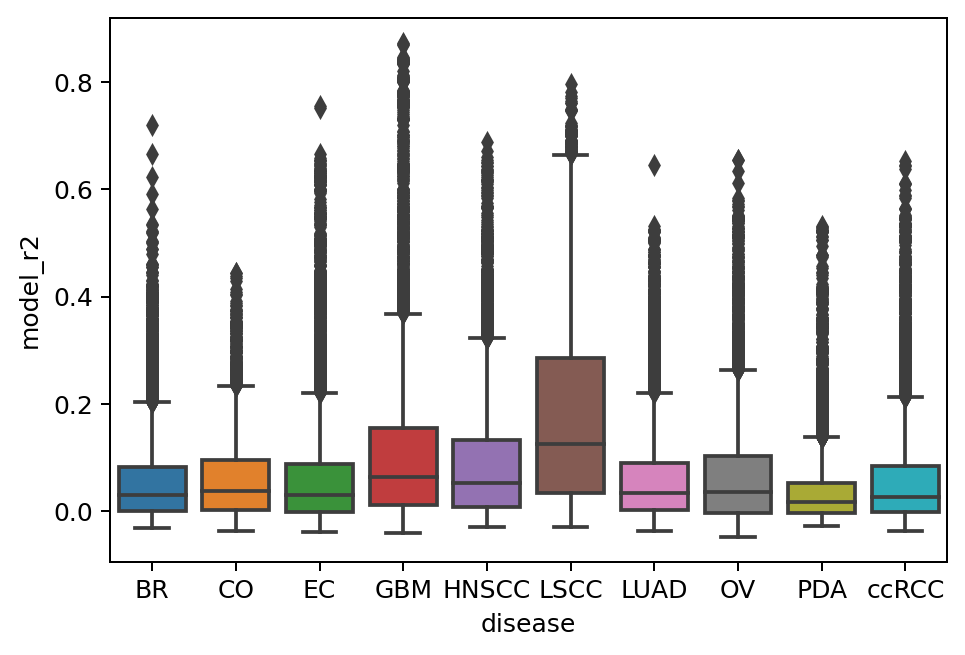

In [251]:
sns.boxplot(data=prot_df2, x='disease', y='model_r2')

<AxesSubplot:xlabel='disease', ylabel='model_r2'>

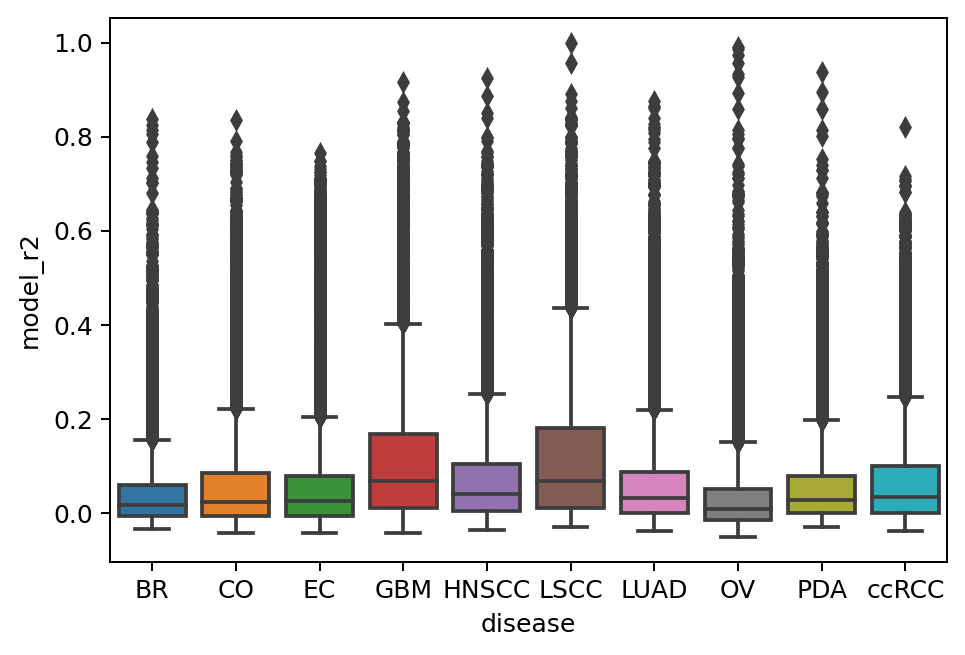

In [252]:
sns.boxplot(data=exp_df2, x='disease', y='model_r2')

In [ ]:
exp_df['label'] = [f'{x}_{y}_{d}' for x, y, d in zip(exp_df['driver'], exp_df['target'], exp_df['disease'])]
exp_df2 = exp_df[['label', 'model_r2']].groupby('label').mean()
exp_df2

In [219]:
def get_performance_diff(df1, df2):
    diseases = sorted(set(df1['disease']))
    data = []
    for disease in diseases:
        df1_filtered = df1[df1['disease']==disease]
        df2_filtered = df2[df2['disease']==disease]

        drivers = sorted(set(df1_filtered['driver']))
        for driver in drivers:
            x_df = df1_filtered[df1_filtered['driver']==driver]
            y_df = df2_filtered[df2_filtered['driver']==driver]
            

In [226]:
perf_diff_df = test_for_difference_model(prot_df, exp_df, to_test='model_r2')
perf_diff_df = perf_diff_df[perf_diff_df['p-value']!=0.]
perf_diff_df['FDR'] = statsmodels.stats.multitest.fdrcorrection(perf_diff_df['p-value'].to_list())[1]
perf_diff_df['-log10(FDR)'] = [-np.log10(x) for x in perf_diff_df['FDR']]
perf_diff_df = perf_diff_df.sort_values('statistic')
perf_diff_df

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:650: RuntimeWarning: divide by zero encountered in double_scalars
  tstat = (value1 - value2 - diff) / std_diff


disease   driver  statistic        p-value            FDR  -log10(FDR)
1641   ccRCC    SF3B1 -10.606859   1.350520e-25   7.722082e-24    23.112266
624      GBM  PPP2R1A -10.232154   4.430059e-24   2.224699e-22    21.652729
1393     PDA    FUBP1  -9.534352   1.680704e-07   1.681755e-06     5.774237
1613   ccRCC    PCBP1  -8.972697   9.782604e-19   3.729035e-17    16.428403
1425     PDA    MAPK1  -8.944548   8.826249e-19   3.446543e-17    16.462616
...      ...      ...        ...            ...            ...          ...
1310      OV    SF3B1  21.691011   5.710994e-94   1.828660e-91    90.737867
309       CO    SF3B1  23.402825  1.685910e-106  6.747856e-104   103.170834
856     LSCC    CDK12  24.042171  3.513445e-107  1.875009e-104   103.726997
948     LSCC    PCBP1  26.448357  3.837964e-124  3.072290e-121   120.512538
976     LSCC    SF3B1  28.408002  2.878048e-150  4.607755e-147   146.336511

[1601 rows x 6 columns]

In [228]:
drivers = ['TP53', 'PIK3CA']
chart = alt.Chart(perf_diff_df).mark_rect().encode(
    x='disease',
    y='driver',
    color='statistic:Q'
)
chart

alt.Chart(...)

<AxesSubplot:xlabel='disease', ylabel='statistic'>

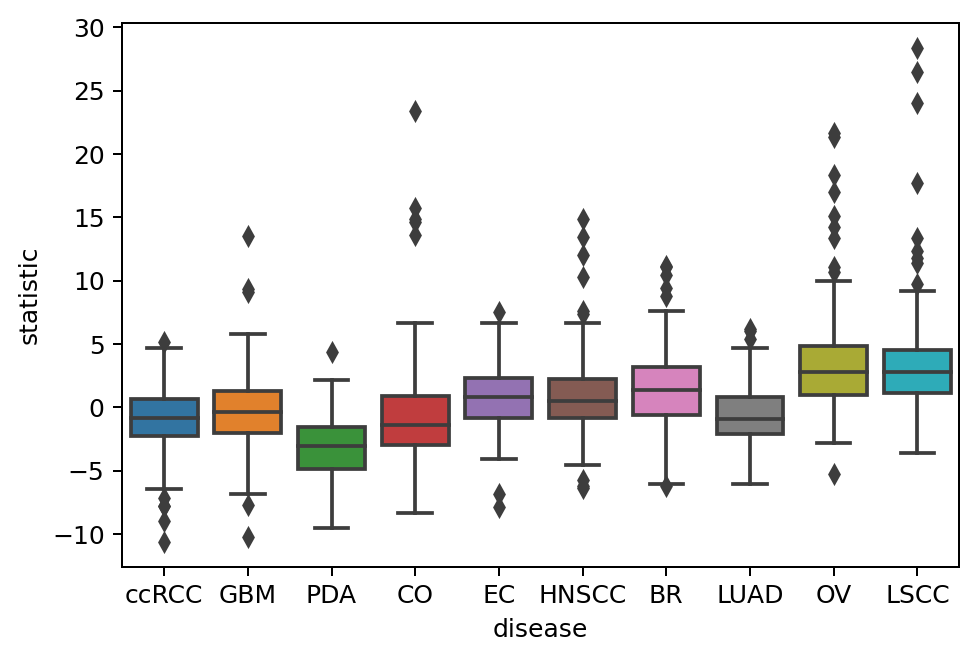

In [229]:
sns.boxplot(data=perf_diff_df, x='disease', y='statistic')

In [ ]:
sns.distplot()

In [245]:
def plot_aggregate_coefficients_boxplot(master_coef_df, figsize=(10, 4)):
    # plot aggregate coefficients accross cancer types
    fig, axs = plt.subplots(figsize=figsize)
    p = master_coef_df[master_coef_df['FDR']<=.05].copy()
    p['coef'] = np.abs(p['coef'])
    p = p[p['feature']!='driver_gene_is_pathogenic_germline']

    # rename coef
    p['feature'] = [x for x in p['feature']]

    sns.boxplot(data=p, x='disease', y='coef', hue='feature')
#     plt.ylim(ylim)
    plt.legend(bbox_to_anchor=(1.5, 1.0))
    plt.tight_layout()

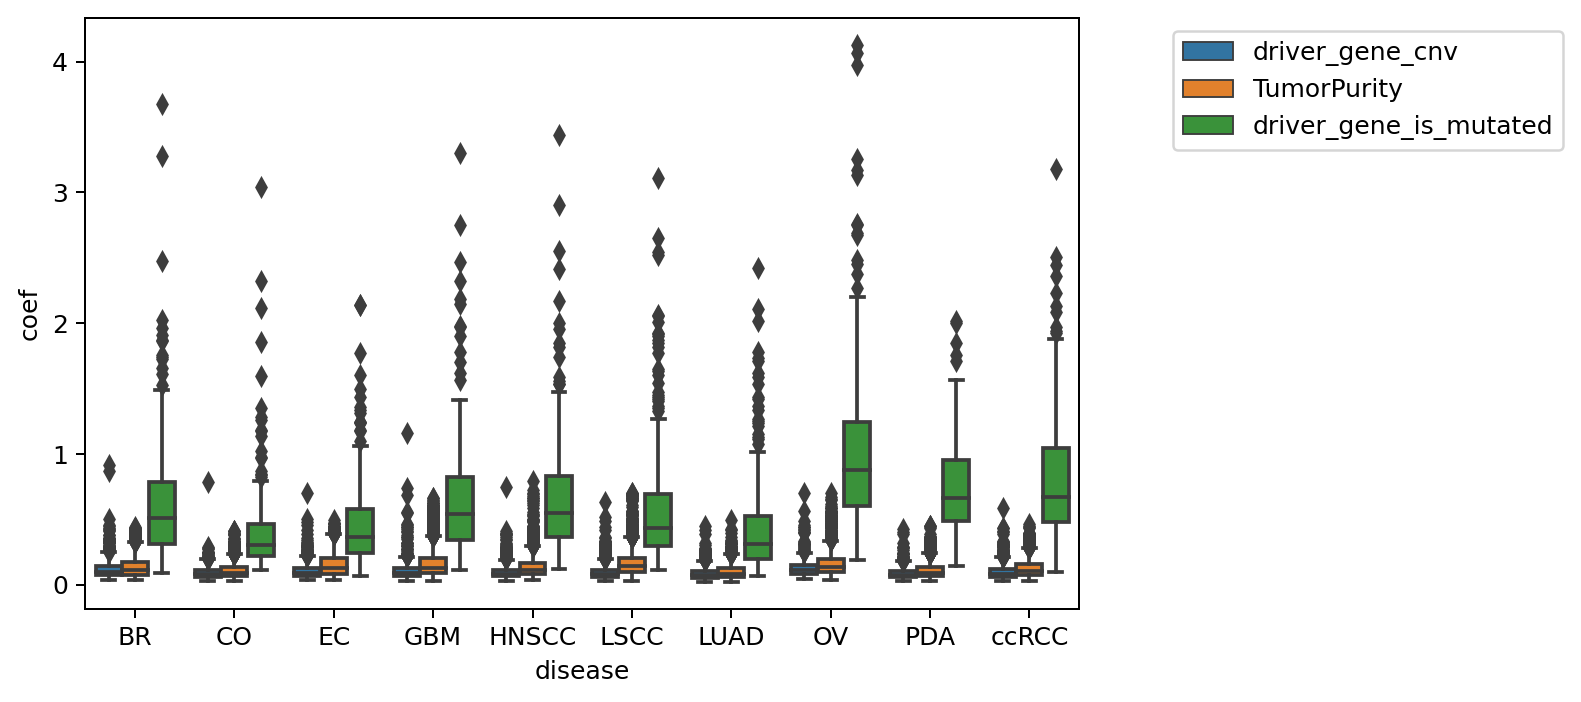

In [246]:
plot_aggregate_coefficients_boxplot(prot_df)

In [244]:
exp_df

coef       p-value           FDR  -log10(FDR)  \
0       -2296.356102  8.825868e-01  9.443458e-01     0.024869   
1       -3697.054627  8.124165e-01  9.069838e-01     0.042400   
2      -55735.594358  6.445640e-01  8.080267e-01     0.092574   
3           0.000000           NaN           NaN          NaN   
4       49168.384392  1.001844e-11  4.381812e-11    10.358346   
...              ...           ...           ...          ...   
621475      0.000000           NaN           NaN          NaN   
621476   2128.848563  1.451161e-01  2.593052e-01     0.586189   
621477  -5312.962544  3.842869e-04  1.157616e-03     2.936436   
621478   4746.539522  7.541457e-01  8.580521e-01     0.066486   
621479      0.000000           NaN           NaN          NaN   

                                   feature  driver   target disease  model_r2  \
0                          driver_gene_cnv    ABL1     ABI1      BR -0.023628   
1                              TumorPurity    ABL1     ABI1      BR -0.023628   
2                   driver_gene_is_mutated    ABL1     ABI1      BR -0.023628   
3       driver_gene_is_pathogenic_germline    ABL1     ABI1      BR -0.023628   
4                          driver_gene_cnv    ABL1     ABL1      BR  0.342304   
...                                    ...     ...      ...     ...       ...   
621475  driver_gene_is_pathogenic_germline  ZNF750  ZSCAN25   ccRCC  0.258600   
621476                         TumorPurity  ZNF750  ZSCAN32   ccRCC  0.118073   
621477                     driver_gene_cnv  ZNF750  ZSCAN32   ccRCC  0.118073   
621478              driver_gene_is_mutated  ZNF750  ZSCAN32   ccRCC  0.118073   
621479  driver_gene_is_pathogenic_germline  ZNF750  ZSCAN32   ccRCC  0.118073   

        model_r2_FDR  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
621475           NaN  
621476           NaN  
621477           NaN  
621478           NaN  
621479           NaN  

[621480 rows x 10 columns]

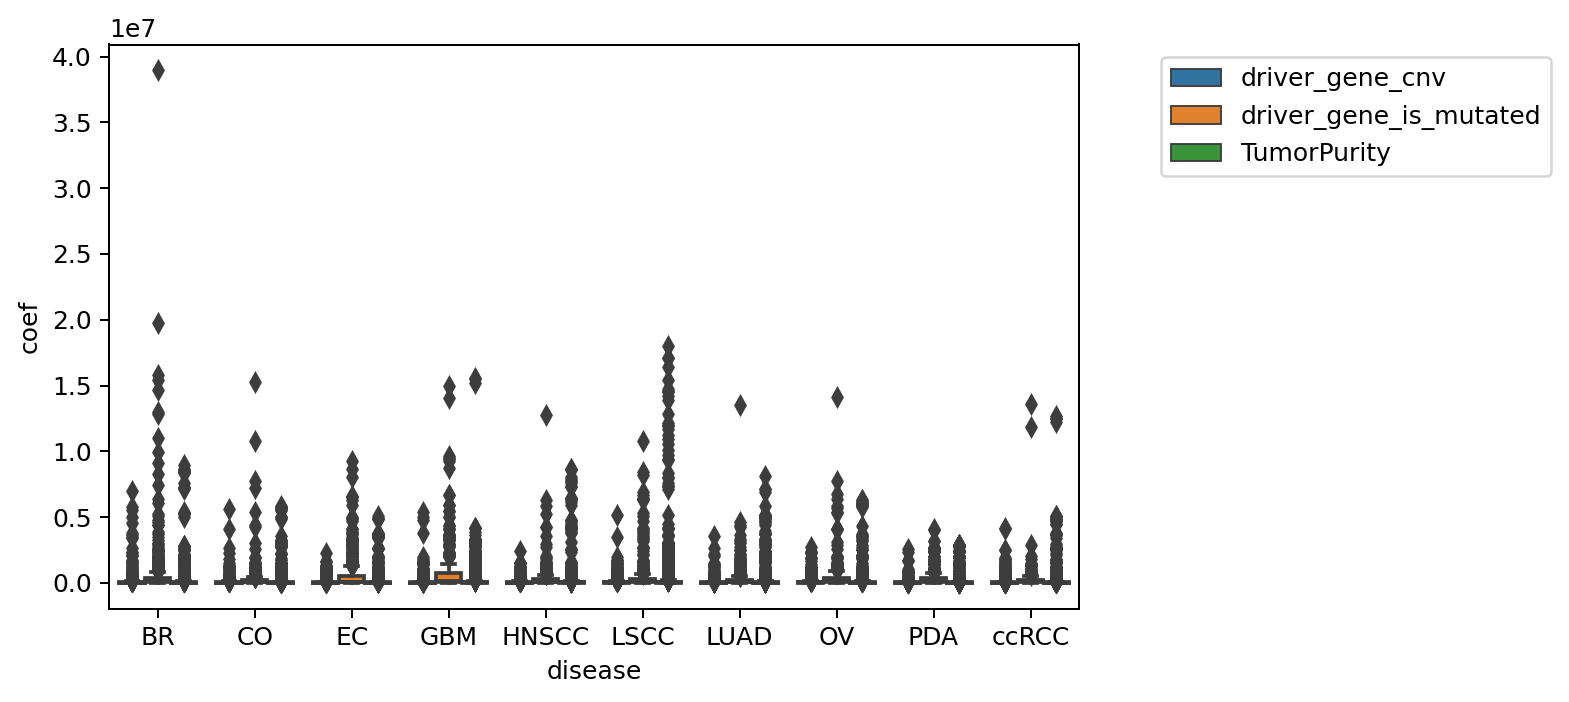

In [247]:
plot_aggregate_coefficients_boxplot(exp_df)

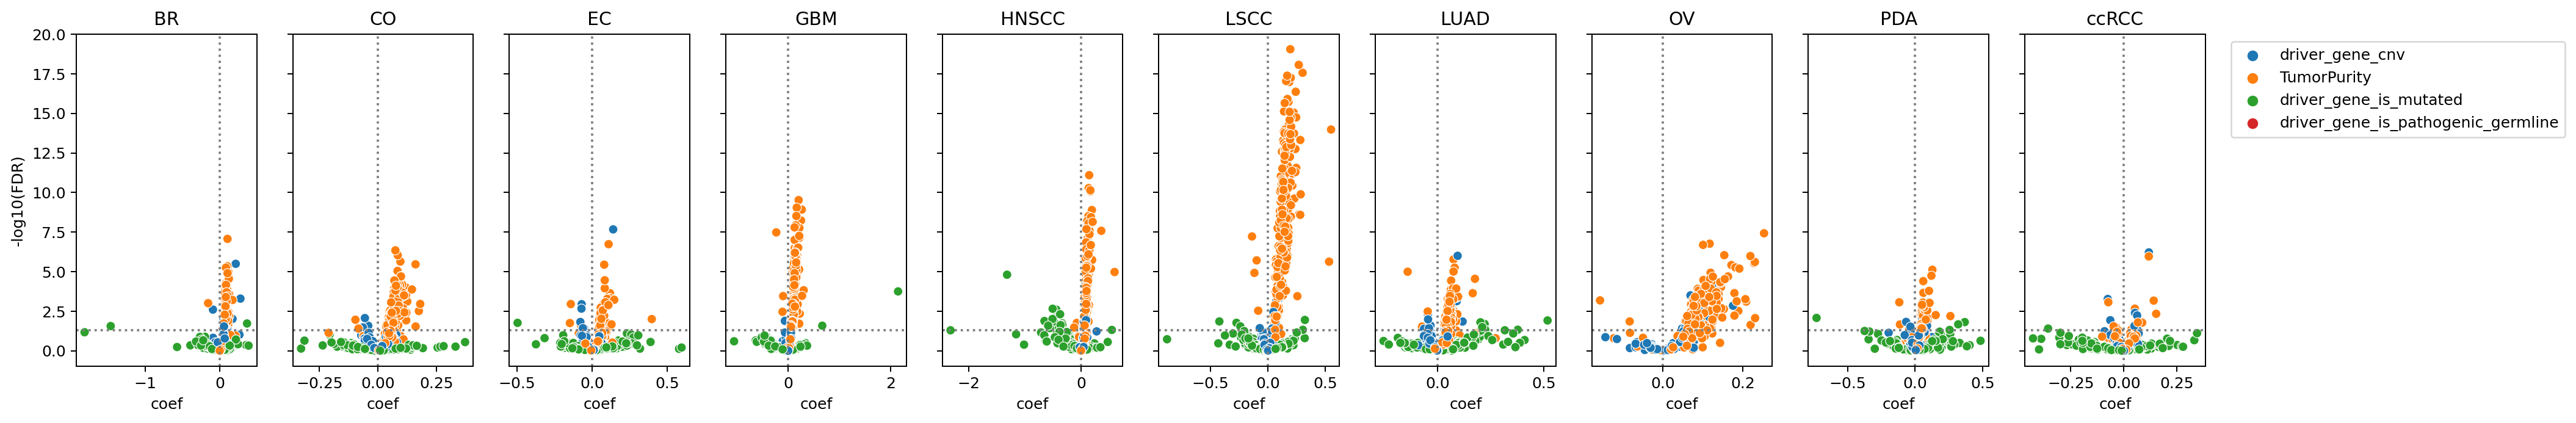

In [230]:
# do by disease
plot_feat_coef_by_disease('SF3B1', prot_df)

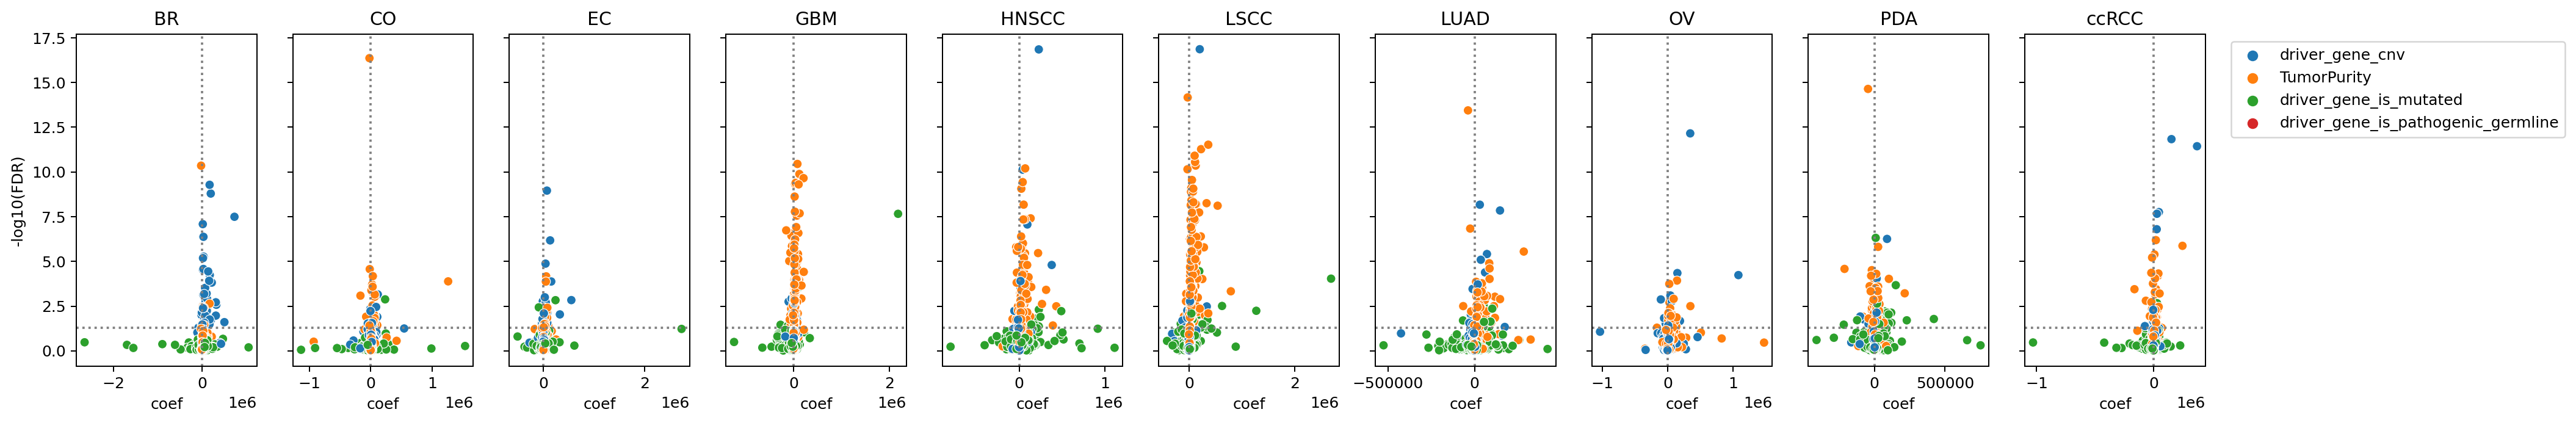

In [231]:
# do by disease
plot_feat_coef_by_disease('SF3B1', exp_df)

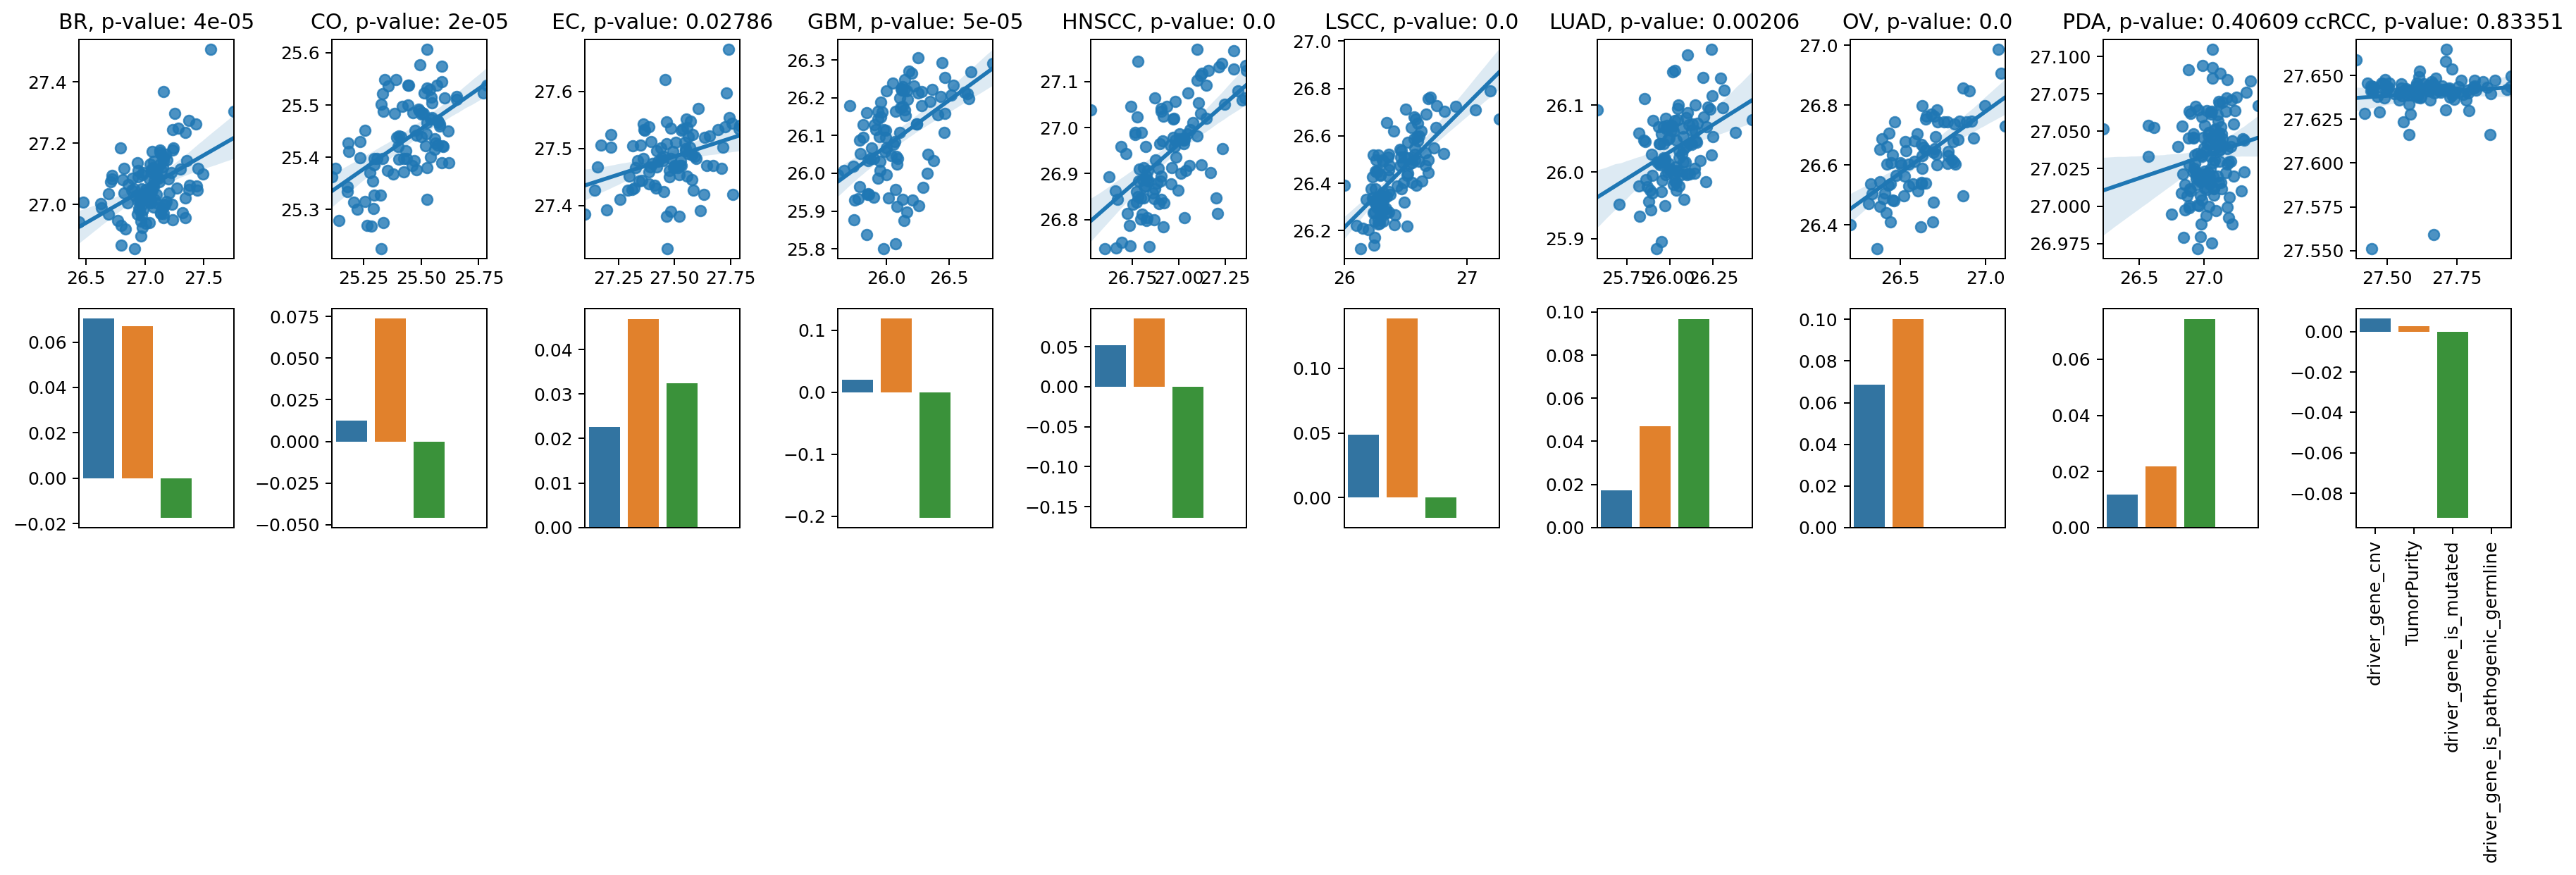

In [239]:
plot_scatter_feature(prot, 'SF3B1_SF3B1', figsize=(20, 7))

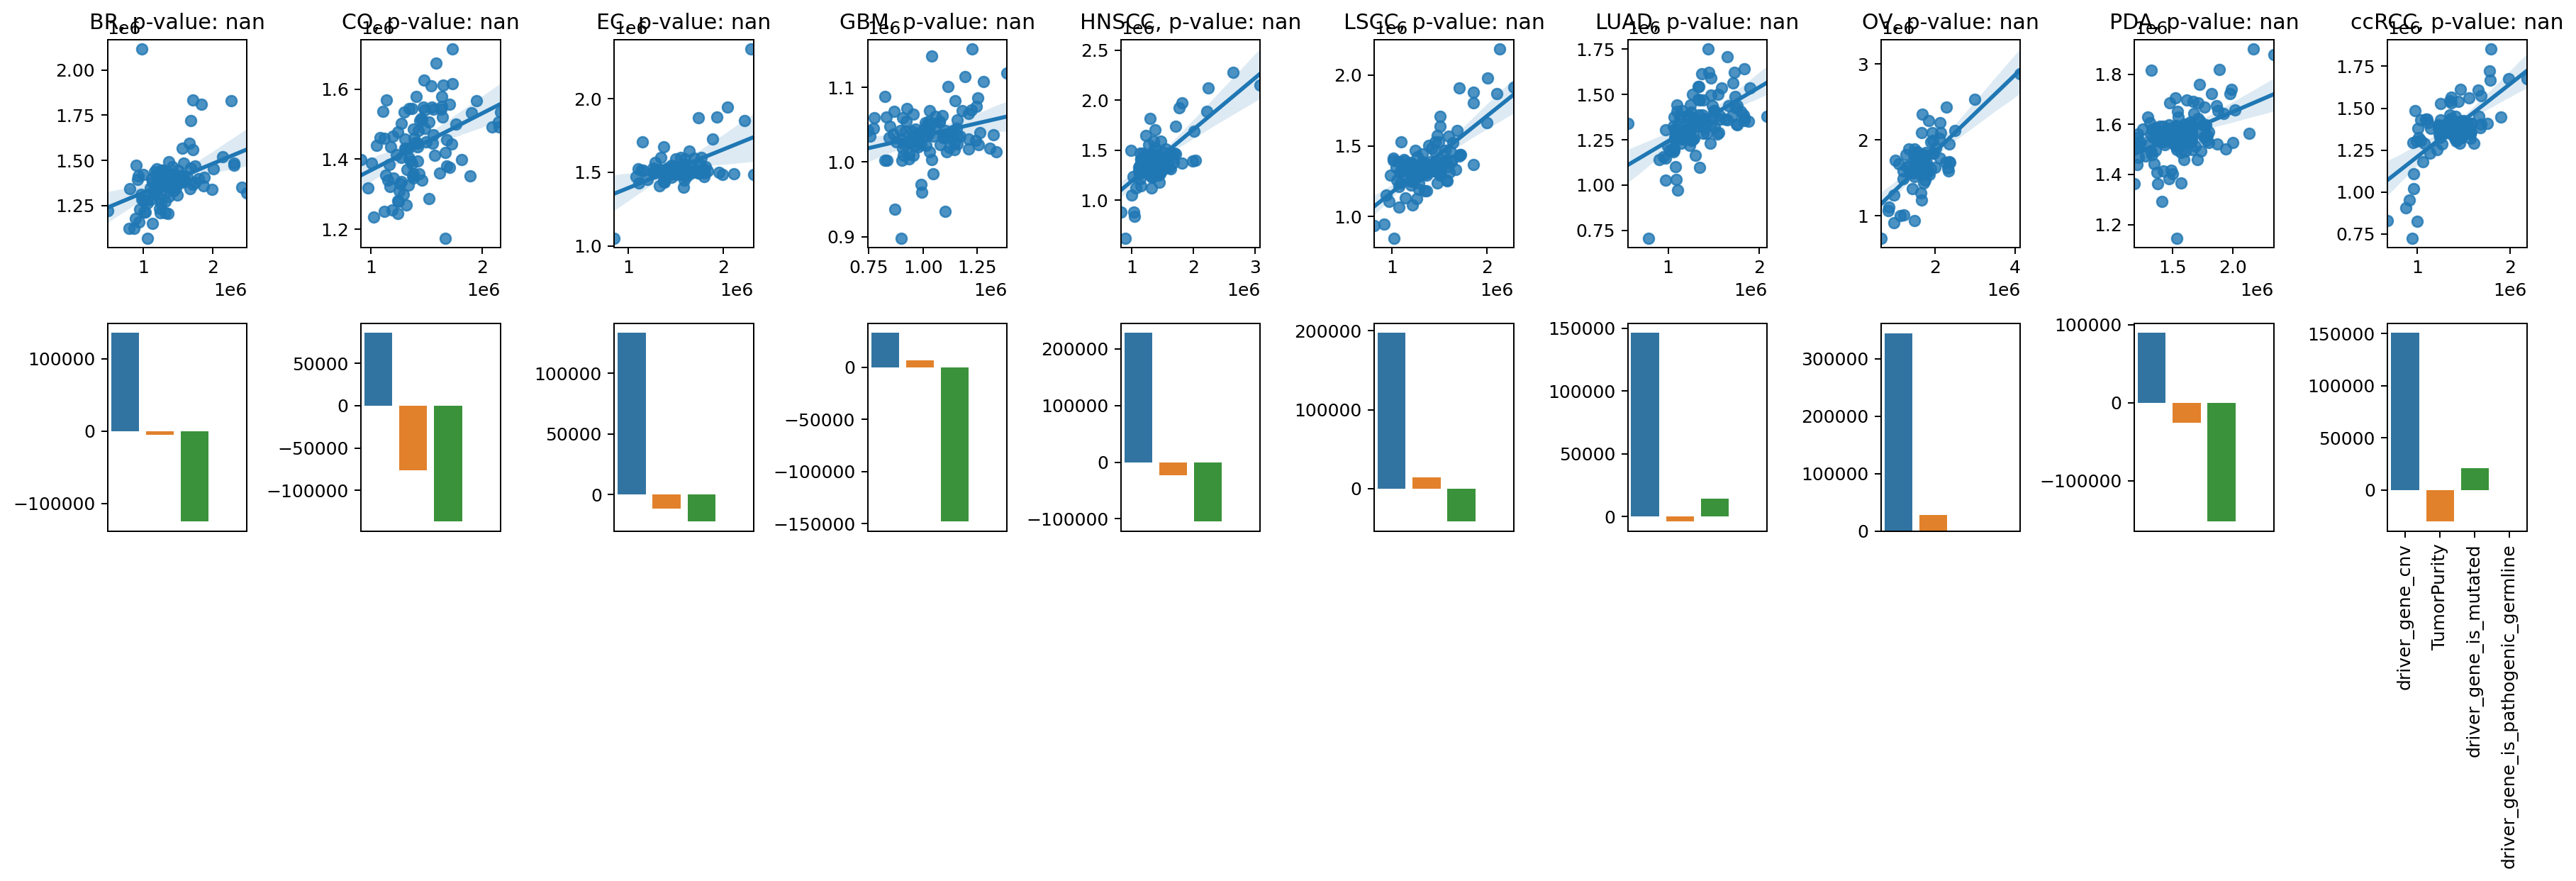

In [240]:
plot_scatter_feature(exp, 'SF3B1_SF3B1', figsize=(20, 7))

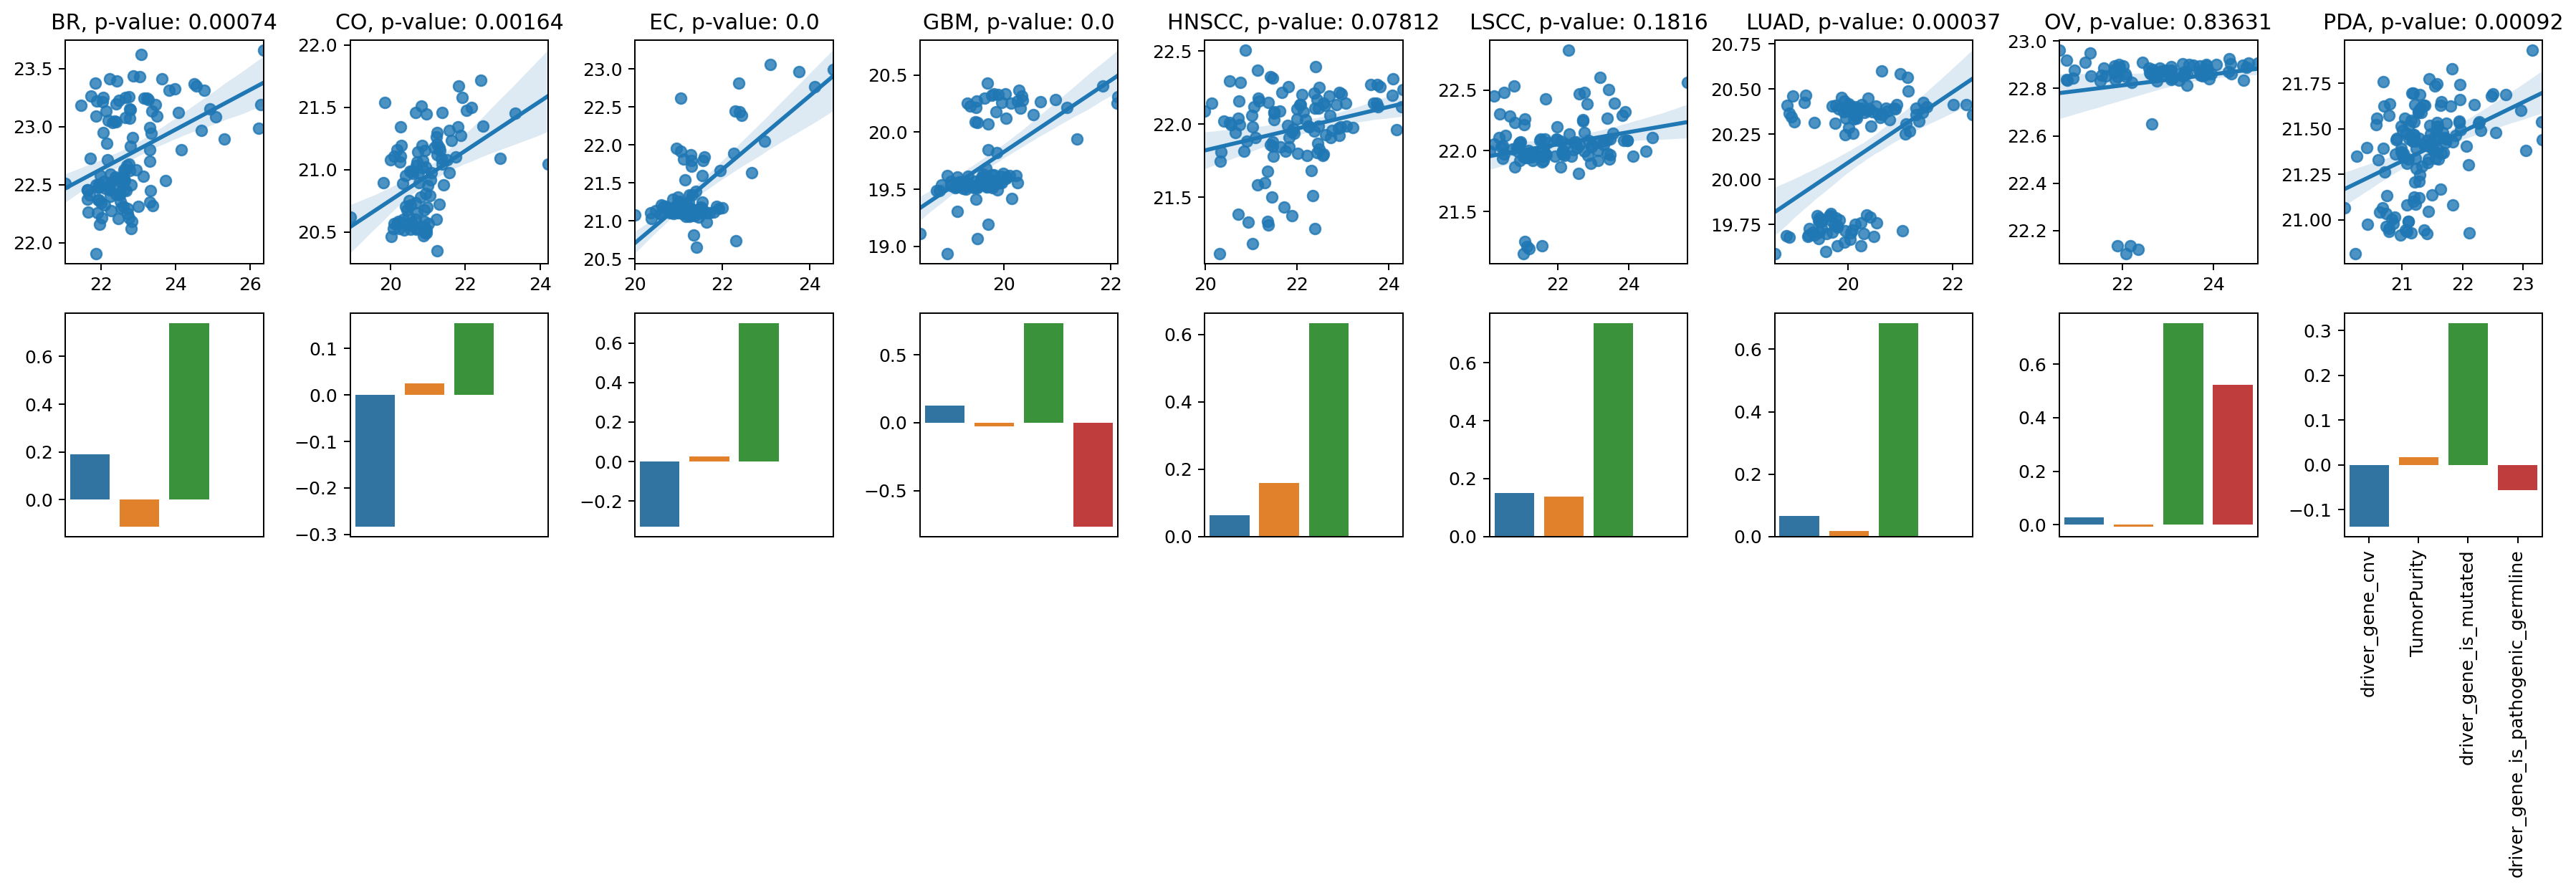

In [232]:
plot_scatter_feature(prot, 'TP53_TP53', figsize=(20, 7))

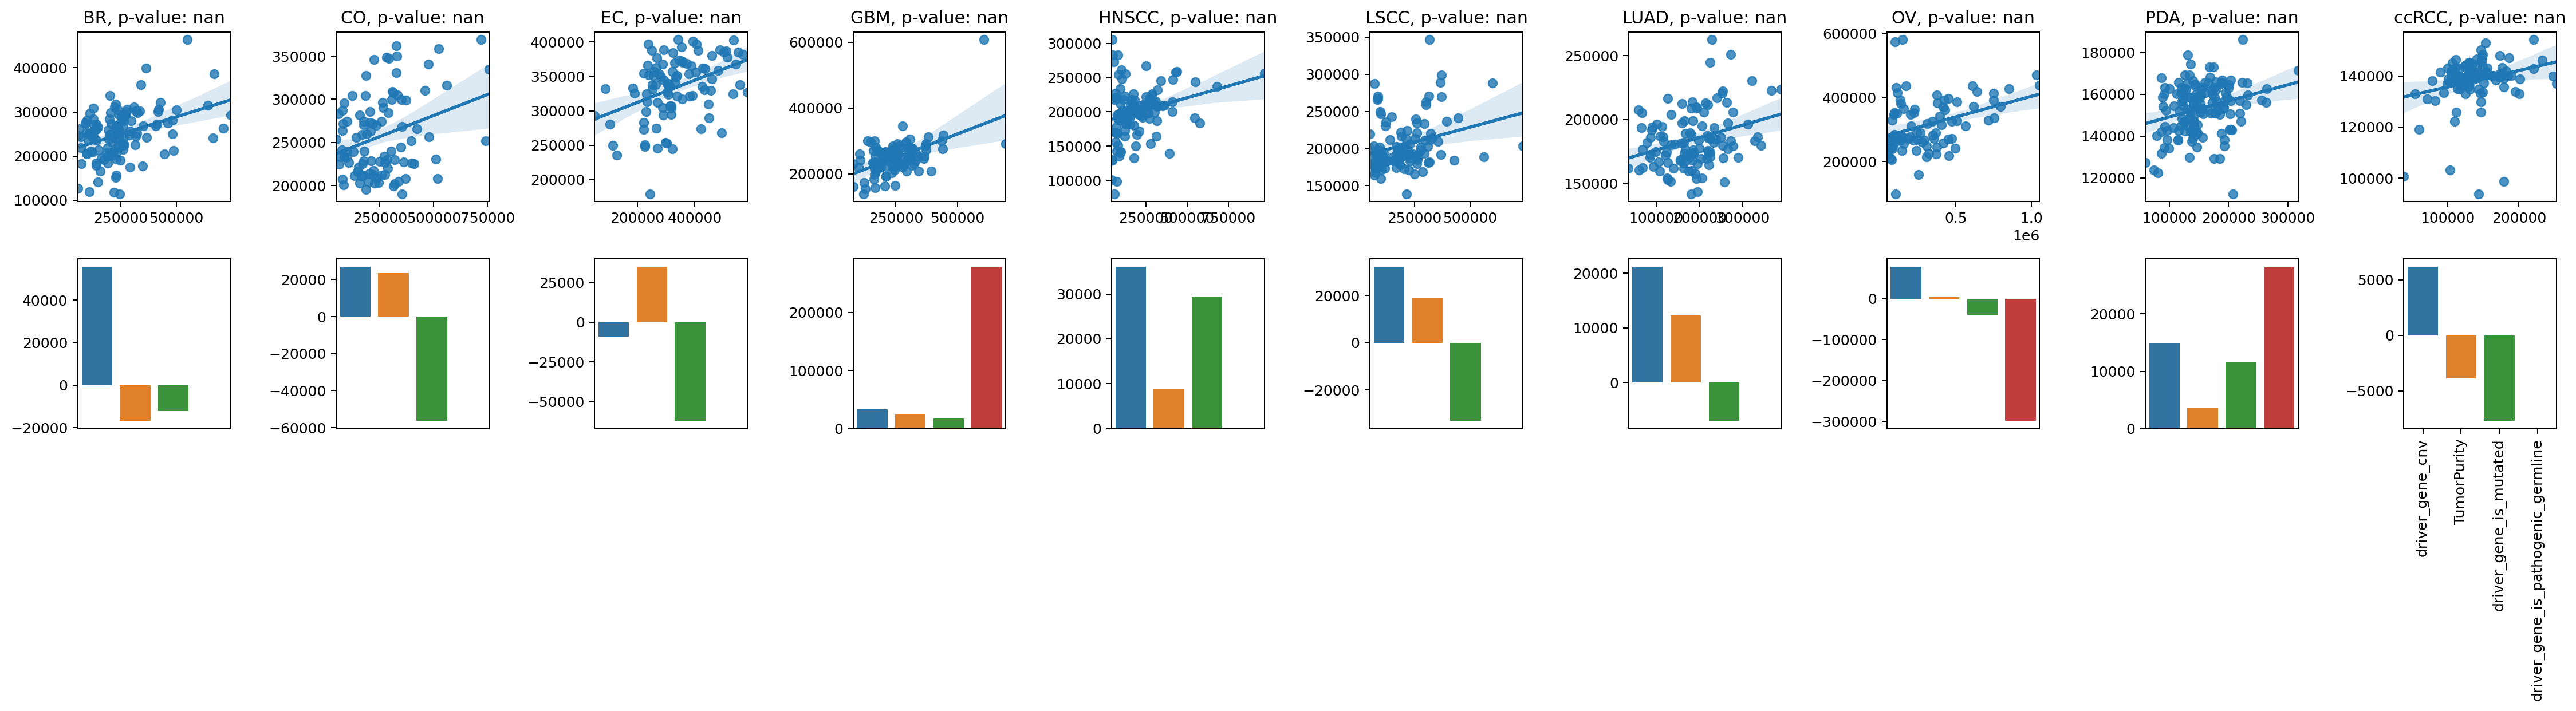

In [234]:
plot_scatter_feature(exp, 'TP53_TP53', figsize=(25, 7))

In [235]:
combined = pd.read_csv('../data/aggregated_05242021.txt.gz', sep='\t')
combined

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cptac_driver/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (60411) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


sample_id  AAAS_proteome  AAK1_proteome  AATF_proteome  \
0       01BR001-T      24.366478      24.512335      25.009167   
1       01BR008-T      24.394392      24.336012      25.198883   
2       01BR009-T      24.126891      24.312230      24.822895   
3       01BR010-T      24.328566      24.399937      24.455721   
4       01BR015-T      24.606059      24.330728      24.259055   
...           ...            ...            ...            ...   
1250  C3N-04119-T      22.997202      24.726521      25.304842   
1251  C3N-04126-T      23.057493      24.772949      25.715299   
1252  C3N-04282-T      22.775772      24.852962      25.724592   
1253  C3N-04283-T      23.116111      24.664143      25.571772   
1254  C3N-04284-T      23.317882      24.885906      25.596316   

      ABCA1_proteome  ABCA2_proteome  ABCB1_proteome  ABCB11_proteome  \
0          22.761127       18.747711             NaN              NaN   
1          22.507570       19.817547             NaN              NaN   
2          23.841045       20.841777             NaN              NaN   
3          23.044677       20.980193             NaN              NaN   
4          22.052379       19.149462             NaN              NaN   
...              ...             ...             ...              ...   
1250       23.719660             NaN       22.479719              NaN   
1251       24.214258             NaN       22.003800              NaN   
1252       23.073272             NaN       21.588377              NaN   
1253       23.463646             NaN       21.701678              NaN   
1254       22.651939             NaN       22.653412              NaN   

      ABCC2_proteome  ABCC3_proteome  ...  snoU2-30_expression  \
0                NaN       19.982433  ...          8605.851979   
1                NaN       19.608661  ...          7100.255609   
2                NaN       19.515286  ...             0.000000   
3                NaN       20.429545  ...             0.000000   
4                NaN       18.981616  ...          6916.346786   
...              ...             ...  ...                  ...   
1250             NaN       24.267079  ...        184418.855703   
1251             NaN       24.271196  ...        161899.622234   
1252             NaN       24.725779  ...        163576.881134   
1253             NaN       24.395560  ...        316347.982781   
1254             NaN       24.464371  ...        261251.632823   

      snoU2_19_expression  snoU83B_expression  snoZ196_expression  \
0            15060.240964                 0.0            0.000000   
1             6212.723658                 0.0        11168.941408   
2             3147.029204                 0.0        56575.805922   
3                0.000000                 0.0        10683.104403   
4             3025.901719                 0.0            0.000000   
...                   ...                 ...                 ...   
1250        257792.821159                 0.0        14151.076897   
1251        178764.166217                 0.0        12127.312527   
1252        131202.290076                 0.0            0.000000   
1253        297827.610371                 0.0        44093.446611   
1254        200020.781380                 0.0        37359.784060   

      snoZ278_expression  snoZ40_expression  snoZ6_expression  \
0                    0.0                0.0          0.000000   
1                    0.0                0.0          0.000000   
2                    0.0                0.0          0.000000   
3                    0.0                0.0          0.000000   
4                    0.0                0.0       3185.159704   
...                  ...                ...               ...   
1250                 0.0                0.0          0.000000   
1251                 0.0                0.0          0.000000   
1252                 0.0                0.0          0.000000   
1253                 0.0                0.0          0.000000   
1

In [236]:
x = combined[['TP53_cnv', 'TP53_is_mutated', 'TP53_is_pathogenic_germline', 'TP53_proteome', 'TP53_expression', 'TumorPurity']].copy()
x.columns = ['TP53 CNV', 'TP53 somatic mutation status', 'TP53 germline mutation status', 'TP53 proteome', 'TP53 expression', 'tumor purity']
x['TP53 somatic mutation status'] = ['mutated' if m else 'wildtype' for m in x['TP53 somatic mutation status']]
x

TP53 CNV TP53 somatic mutation status  TP53 germline mutation status  \
0      0.22080                      mutated                              0   
1     -0.02004                      mutated                              0   
2      0.34555                     wildtype                              0   
3     -0.14187                     wildtype                              0   
4     -0.18660                      mutated                              0   
...        ...                          ...                            ...   
1250  -0.14516                      mutated                              0   
1251  -0.19759                      mutated                              0   
1252  -0.29080                     wildtype                              0   
1253  -0.16036                      mutated                              0   
1254  -0.04971                     wildtype                              0   

      TP53 proteome  TP53 expression  tumor purity  
0         24.567060    641590.753257      0.816624  
1         24.501803    481864.908112      0.510466  
2         24.686889    363827.278756      0.556239  
3         22.699751    263787.995617      0.747700  
4         22.767829    485866.332883      0.649161  
...             ...              ...           ...  
1250      21.011950    107353.679015      0.530830  
1251      20.590258    106945.888671      0.464536  
1252      20.423161     80901.845005      0.604708  
1253      21.727599    180320.303553      0.661656  
1254      20.048292    143399.968912      0.723917  

[1255 rows x 6 columns]

<AxesSubplot:xlabel='TP53 somatic mutation status', ylabel='TP53 proteome'>

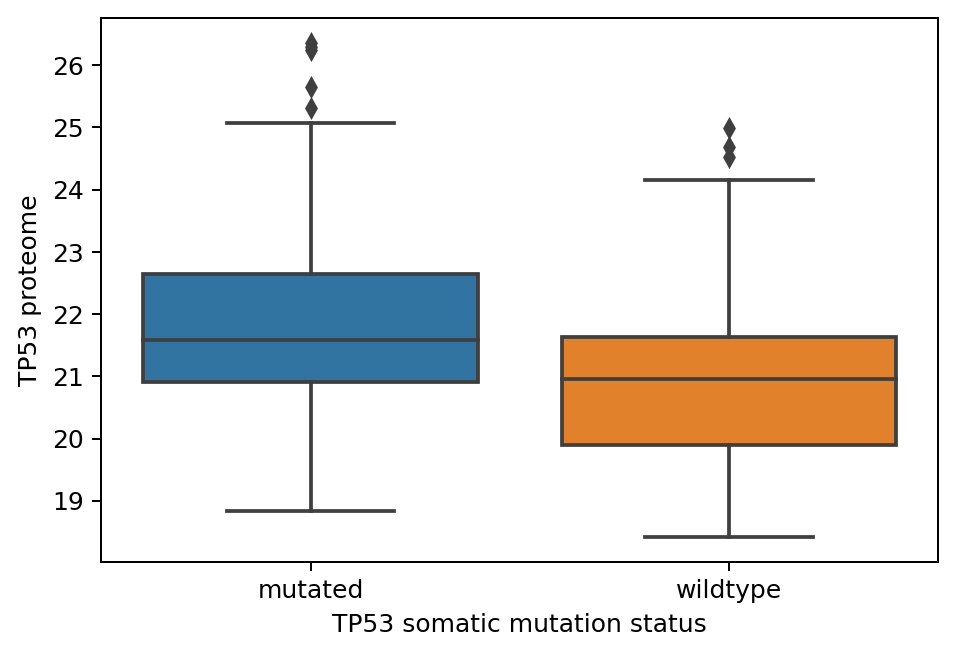

In [237]:
sns.boxplot(data=x, x='TP53 somatic mutation status', y='TP53 proteome')

<AxesSubplot:xlabel='TP53 somatic mutation status', ylabel='TP53 expression'>

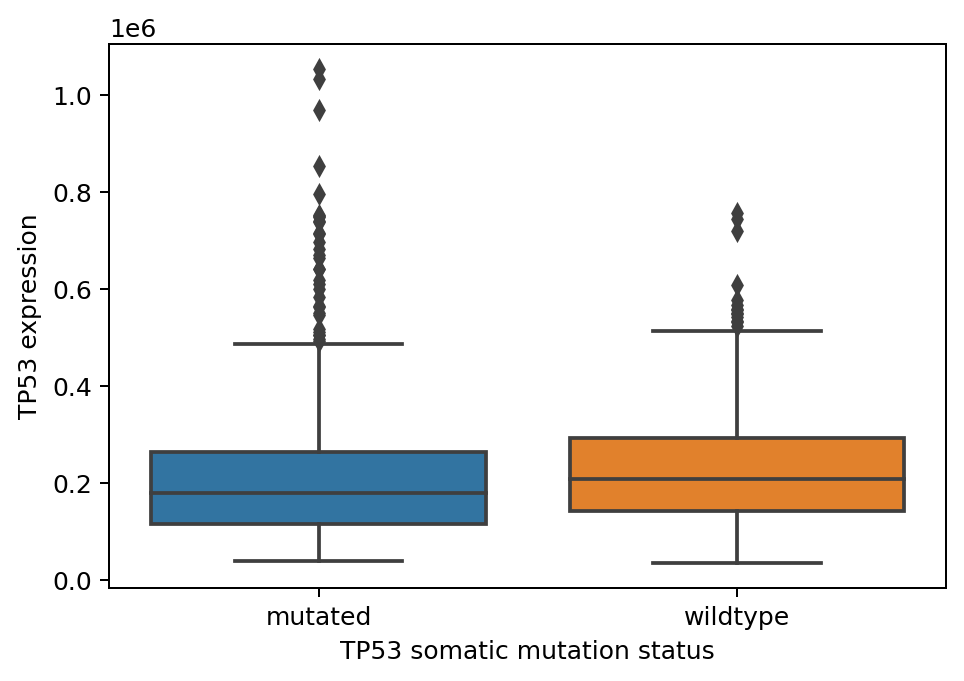

In [238]:
sns.boxplot(data=x, x='TP53 somatic mutation status', y='TP53 expression')

In [ ]:
x = combined[['TP53_cnv', 'TP53_is_mutated', 'TP53_is_pathogenic_germline', 'ESR1_proteome', 'TumorPurity']].copy()
x.columns = ['TP53 CNV', 'TP53 somatic mutation status', 'TP53 germline mutation status', 'ESR1 proteome', 'tumor purity']
x['TP53 somatic mutation status'] = ['mutated' if m else 'wildtype' for m in x['TP53 somatic mutation status']]
x

In [ ]:
# plot volcano
def plot_volcano(df, feat, fdr='-log10(FDR)', label=None, label_cut=.05, ax=None, size=6, hue=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    sns.scatterplot(data=df, x=feat, y=fdr, ax=ax, hue=hue)
    ax.axhline(y=-np.log10(.05), linestyle='dotted', color='gray')
    ax.axvline(x=0., linestyle='dotted', color='gray')
    
    if label is not None:
        for x, y, l in zip(df[feat], df[fdr], df[label]):
            if y >= -np.log10(label_cut):
                ax.annotate(l, (x, y), fontsize=size)
    
    return ax

<AxesSubplot:xlabel='statistic', ylabel='-log10(FDR)'>

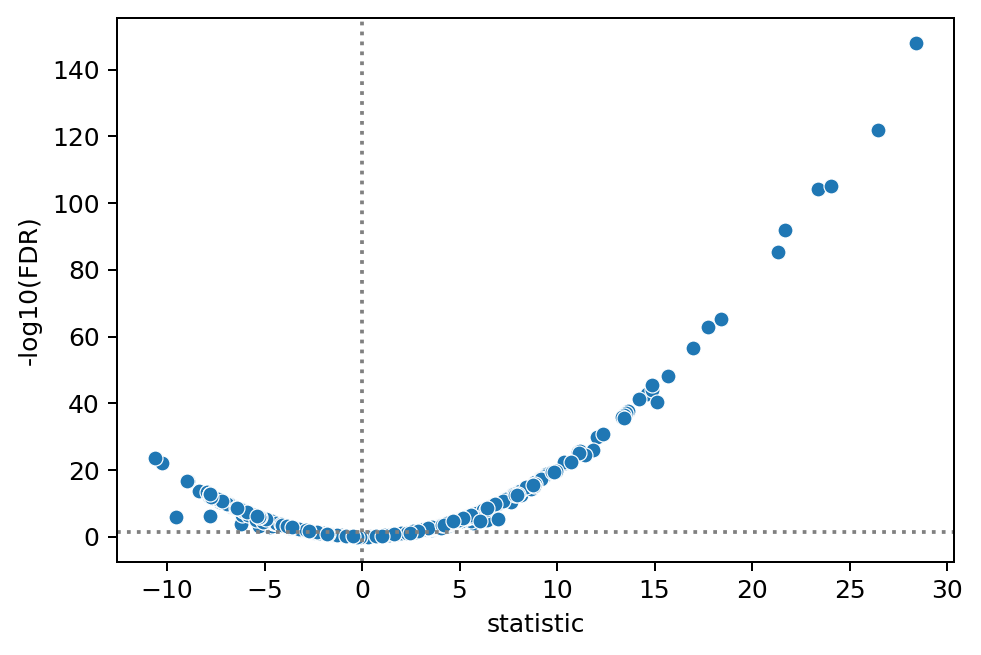

In [224]:
plot_volcano(perf_diff_df, 'statistic')

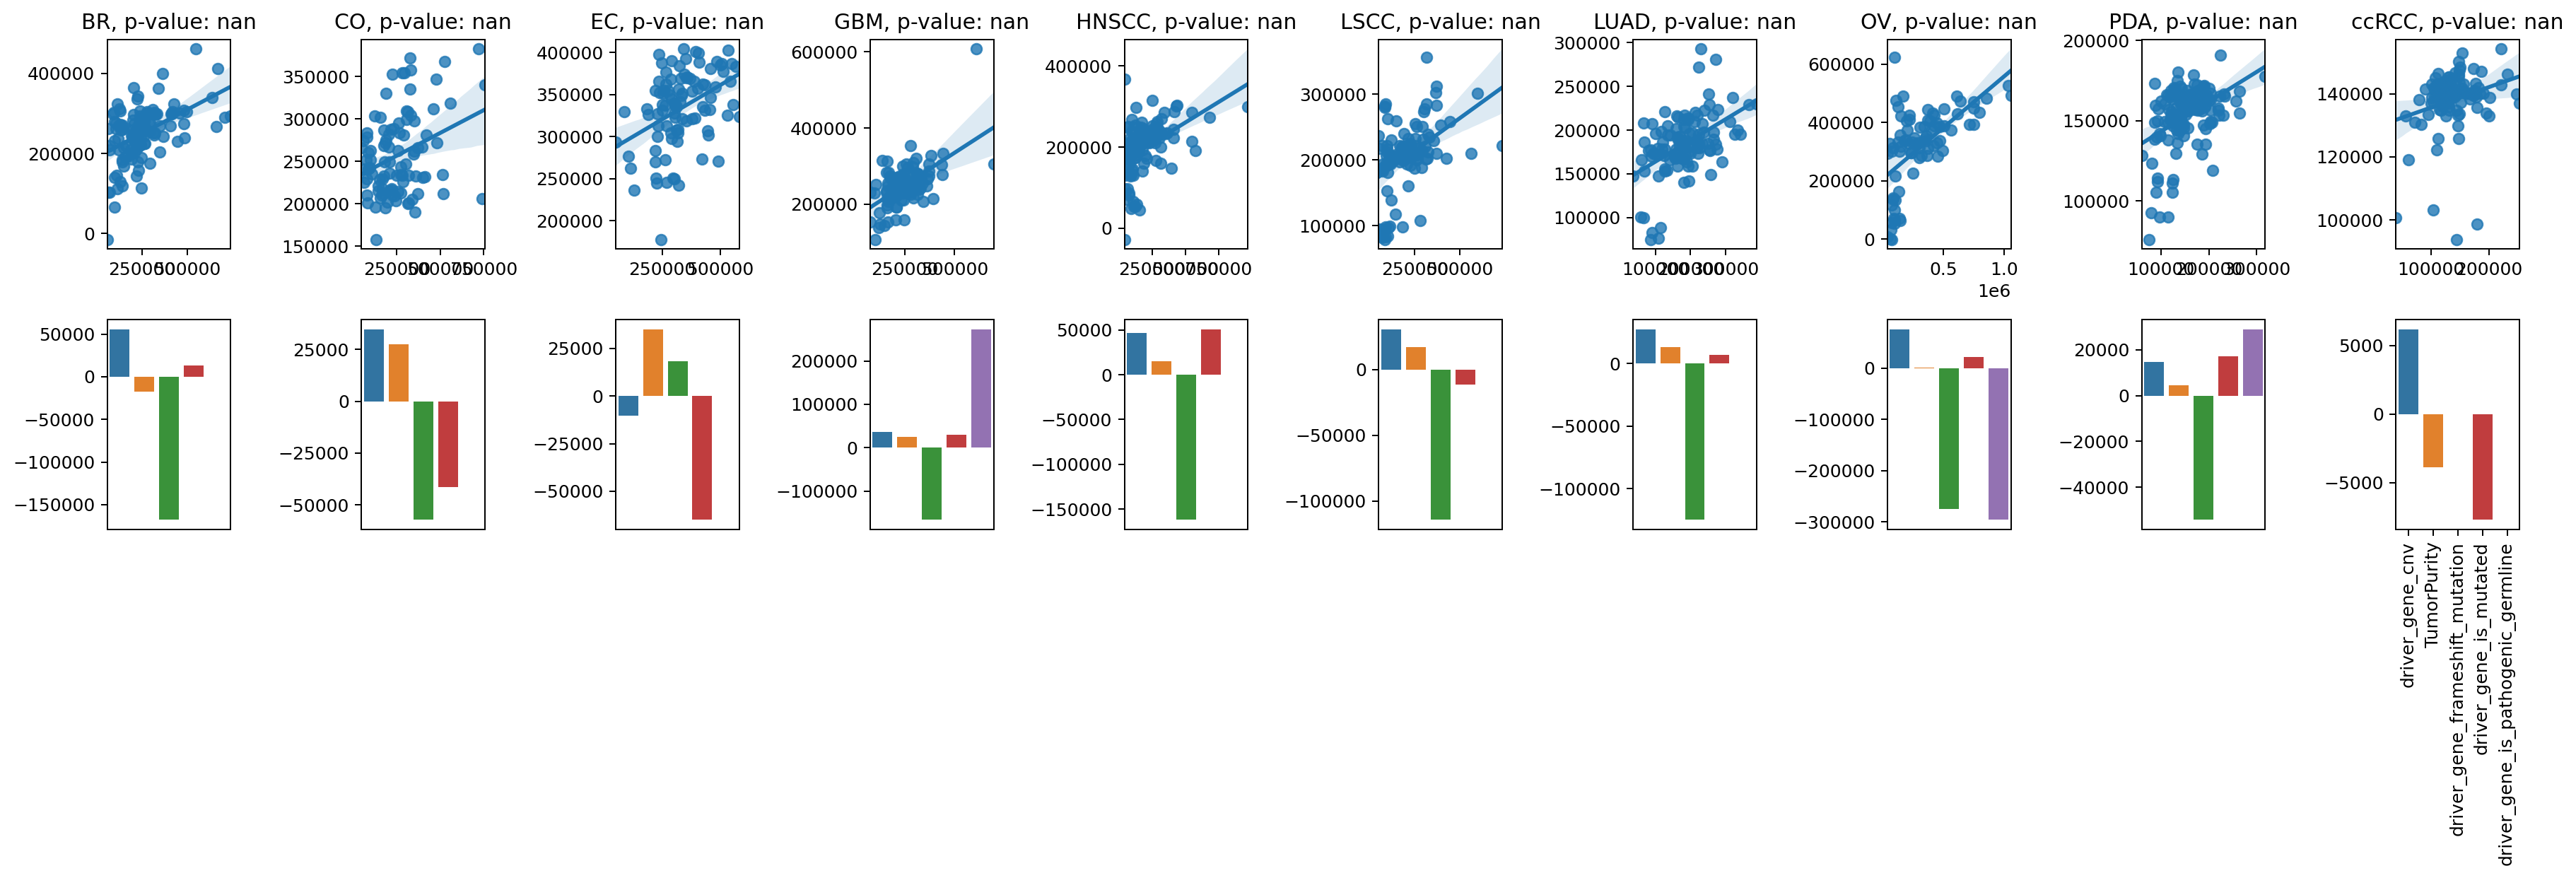

In [40]:
plot_scatter_feature(exp, 'TP53_TP53', figsize=(20, 7))

##### immune subtype

In [78]:
subtypes = pd.read_csv('../data/immune_subtype.txt', sep='\t')
subtypes = subtypes.set_index('case')
subtypes

Immune_subtype disease
case                               
01BR001-T                 1      BR
01BR008-T                 2      BR
01BR009-T                 3      BR
01BR010-T                 3      BR
01BR015-T                 3      BR
...                     ...     ...
C3N-01520-T               3    UCEC
C3N-01521-T               3    UCEC
C3N-01537-T               4    UCEC
C3N-01802-T               4    UCEC
C3N-01825-T               5    UCEC

[1088 rows x 2 columns]

In [79]:
trunc_df

Unnamed: 0      coef       p-value           FDR  -log10(FDR)  \
0                0 -0.034225  7.199437e-02  1.367462e-01     0.864085   
1                1 -0.010397  5.822843e-01  7.083697e-01     0.149740   
2                2  0.000000           NaN           NaN          NaN   
3                3  0.000000           NaN           NaN          NaN   
4                4  0.179430  6.365821e-11  2.023076e-10     9.693988   
...            ...       ...           ...           ...          ...   
378847      378847  0.000000           NaN           NaN          NaN   
378848      378848  0.063912  1.978743e-01  3.142604e-01     0.502710   
378849      378849 -0.002489  9.598520e-01  9.759316e-01     0.010581   
378850      378850  0.000000           NaN           NaN          NaN   
378851      378851  0.000000           NaN           NaN          NaN   

                                   feature  driver  target disease  model_r2  \
0                          driver_gene_cnv    ABL1    ABI1      BR  0.012191   
1                              TumorPurity    ABL1    ABI1      BR  0.012191   
2          driver_gene_frameshift_mutation    ABL1    ABI1      BR  0.012191   
3       driver_gene_is_pathogenic_germline    ABL1    ABI1      BR  0.012191   
4                          driver_gene_cnv    ABL1    ABL1      BR  0.298532   
...                                    ...     ...     ...     ...       ...   
378847  driver_gene_is_pathogenic_germline  ZNF750  ZNF706   ccRCC  0.017500   
378848                         TumorPurity  ZNF750  ZNF740   ccRCC -0.002408   
378849                     driver_gene_cnv  ZNF750  ZNF740   ccRCC -0.002408   
378850     driver_gene_frameshift_mutation  ZNF750  ZNF740   ccRCC -0.002408   
378851  driver_gene_is_pathogenic_germline  ZNF750  ZNF740   ccRCC -0.002408   

        model_r2_FDR  
0       2.913434e-01  
1       2.913434e-01  
2       2.913434e-01  
3       2.913434e-01  
4       2.121188e-08  
...              ...  
378847  2.551888e-01  
378848  5.479731e-01  
378849  5.479731e-01  
378850  5.479731e-01  
378851  5.479731e-01  

[378852 rows x 11 columns]

##### methylation subtype

In [ ]:
subtypes = pd.read_csv('../data/methylation_subtypes.csv')
subtypes